# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [182]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import seaborn as sns

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [183]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep=';')

In [184]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

azdias.shape

(891221, 85)

In [185]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [186]:
feat_info.shape

(85, 4)

In [187]:
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [188]:
def get_null_stats(df):
    
    null_columns = df.isnull().sum()[df.isnull().sum() != 0]
    data_dict = {'null_count':null_columns.values,'percent':np.round((null_columns.values/df.shape[0]) * 100,2)}
    null_stats = pd.DataFrame(data=data_dict,index=null_columns.index)
    null_stats.sort_values(by='percent',ascending=False,inplace=True)
    
    return null_stats

In [189]:
azdias_null_stats_before = get_null_stats(azdias)
azdias_null_stats_before

,null_count,percent
KK_KUNDENTYP,584612,65.60
KBA05_BAUMAX,133324,14.96
KBA05_ANTG4,133324,14.96
KBA05_ANTG1,133324,14.96
KBA05_ANTG2,133324,14.96
KBA05_GBZ,133324,14.96
MOBI_REGIO,133324,14.96
KBA05_ANTG3,133324,14.96
KKK,121196,13.60
REGIOTYP,121196,13.60


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [190]:
# Identify missing or unknown data values and convert them to NaNs.

col1 = feat_info.attribute[57]
col1_miss = feat_info.missing_or_unknown[57].split(",")
col1,col1_miss

('CAMEO_DEUG_2015', ['[-1', 'X]'])

In [191]:
def is_int(value):
  try:
    int(value)
    return True
  except ValueError:
    return False

In [192]:
l1=[]
for elems in col1_miss:
    
    v = re.sub('[^-0-9a-zA-Z{1,2}]+','',elems)
    
    if is_int(v):
        
        l1.append(int(v))
    else:
        l1.append(v)

l1

[-1, 'X']

In [193]:
def convert_unknows(col,code):
    
    #print ('Converting {} for codes = {}'.format(col,code))
    col_codes=[]
    
    for elems in code:
        
        v = re.sub('[^-0-9a-zA-Z{1,2}]+','',elems)

        if is_int(v):
        
            col_codes.append(int(v))
        else:
            
            col_codes.append(v)

        
    #print('col_codes = {}'.format(col_codes))
    
    azdias[col] = azdias[col].replace(col_codes,np.nan)

In [194]:
for feature in range(feat_info.shape[0]):
    
    col = feat_info.attribute[feature]
    col_miss = feat_info.missing_or_unknown[feature].split(",")
    
    convert_unknows(col,col_miss)

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [195]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

azdias_null_stats_after = get_null_stats(azdias)
azdias_null_stats_after

,null_count,percent
TITEL_KZ,889061,99.76
AGER_TYP,685843,76.96
KK_KUNDENTYP,584612,65.60
KBA05_BAUMAX,476524,53.47
GEBURTSJAHR,392318,44.02
ALTER_HH,310267,34.81
KKK,158064,17.74
REGIOTYP,158064,17.74
W_KEIT_KIND_HH,147988,16.61
KBA05_ANTG3,133324,14.96


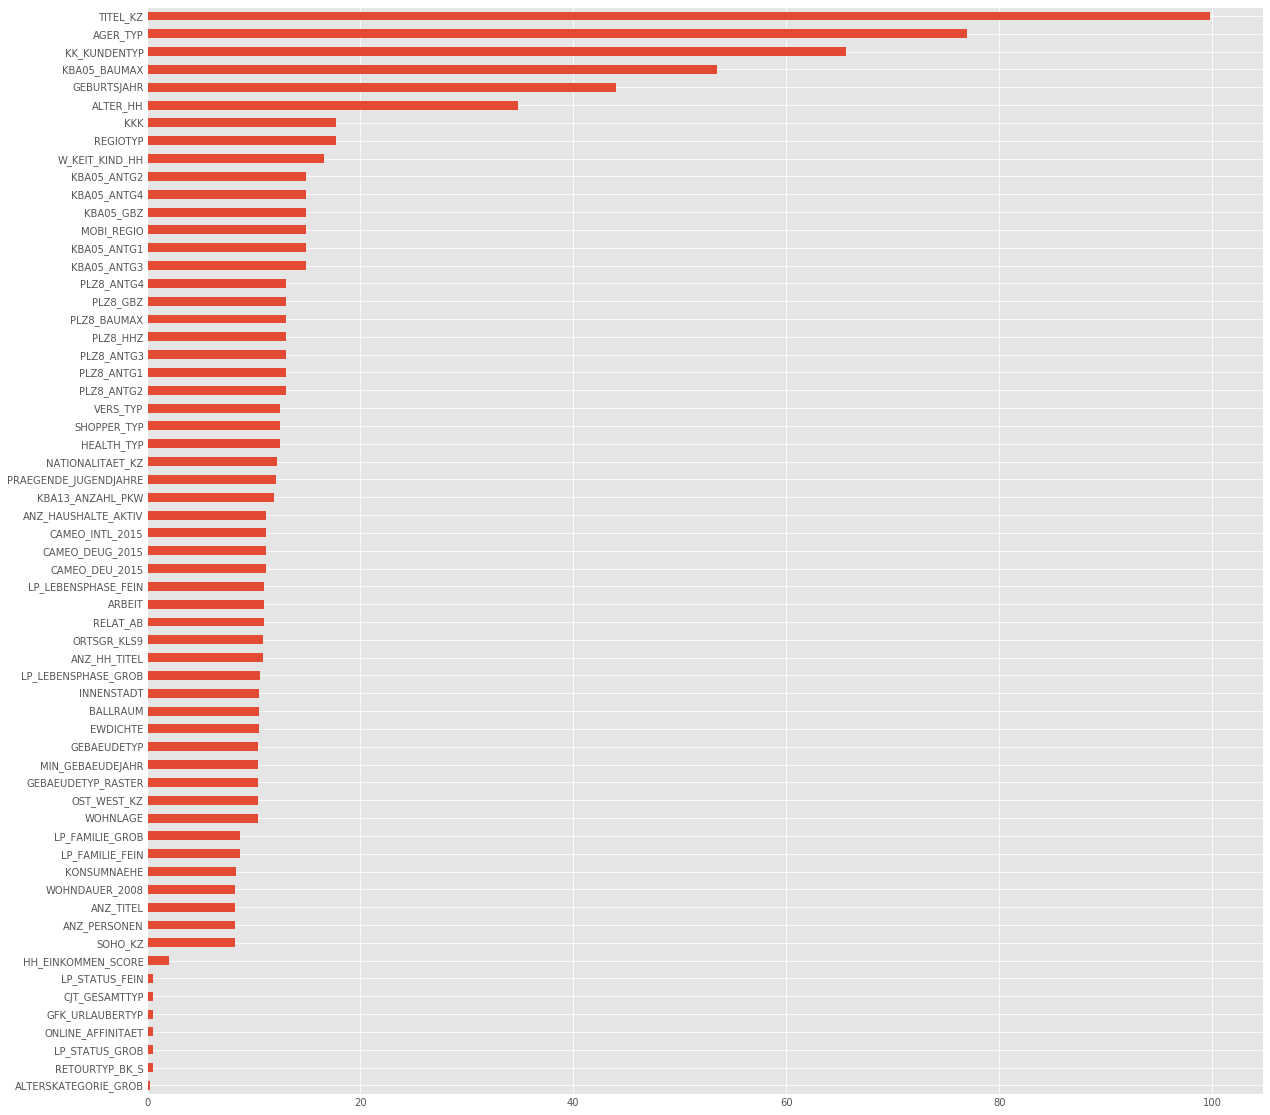

In [196]:
azdias_null_stats_after.percent.sort_values().plot.barh(figsize=(20,20));

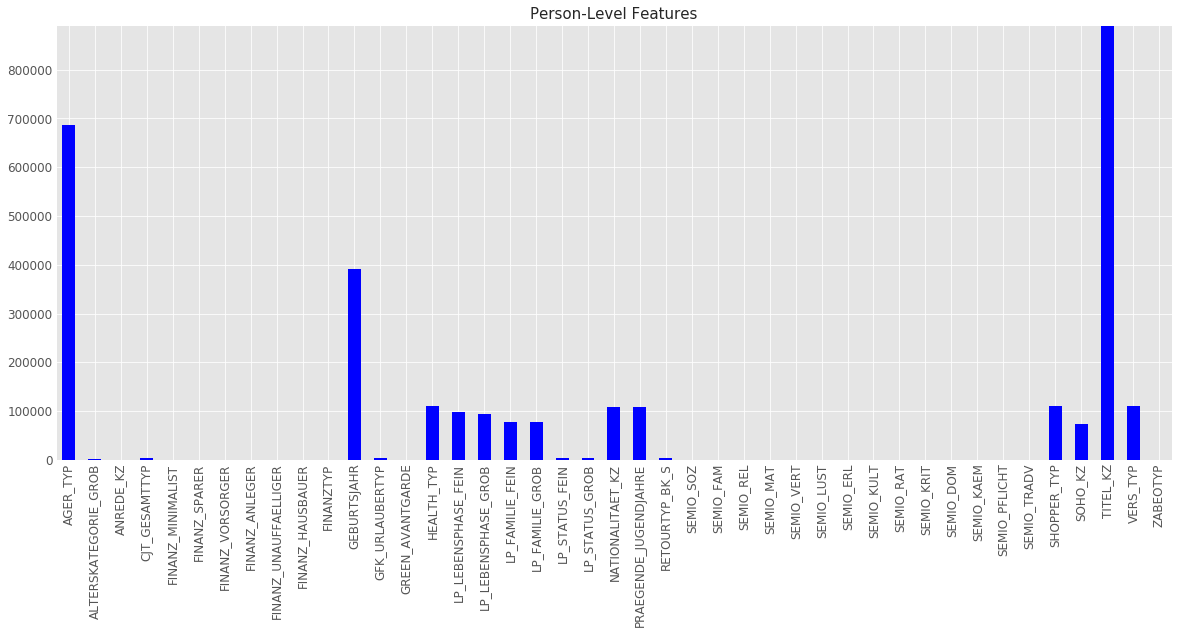

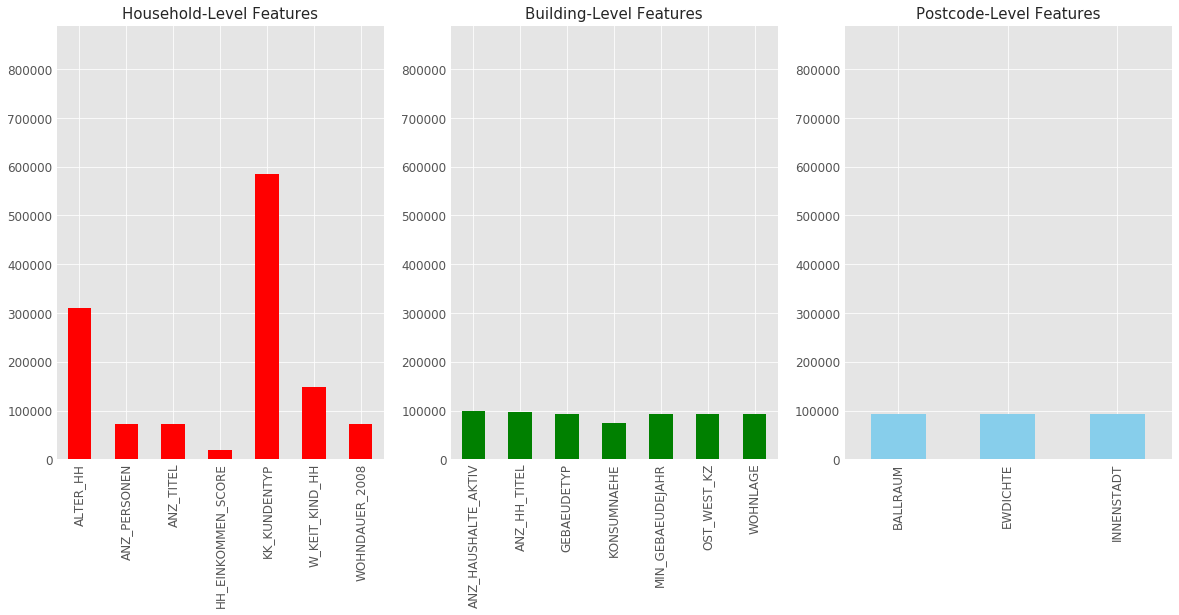

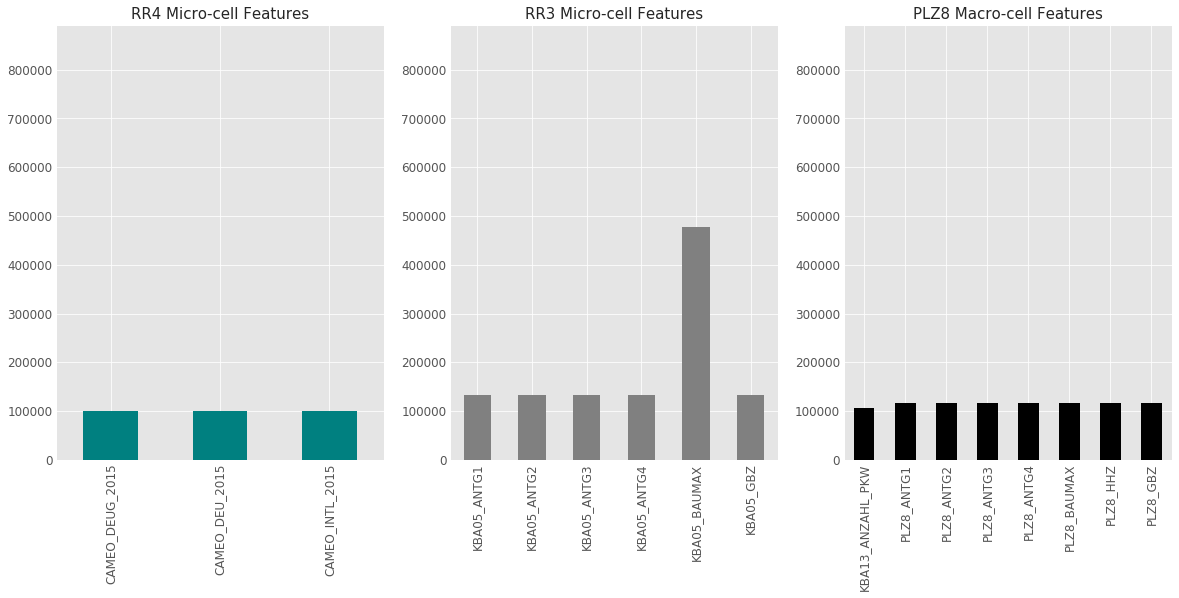

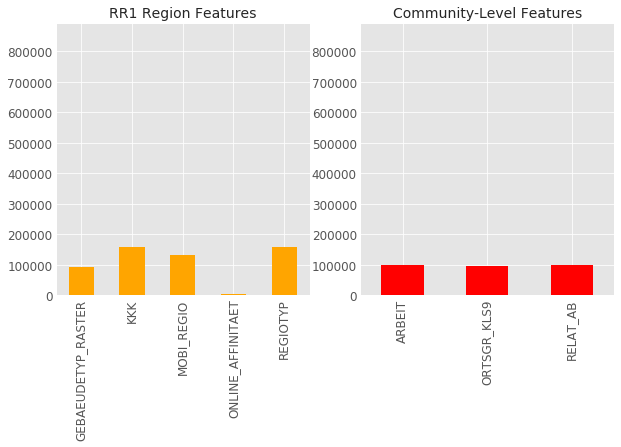

In [197]:
# Investigate patterns in the amount of missing data in each column.
ylimit = azdias.shape[0]

#Person-level features
plt.figure(1,figsize=(20,8))
plt.subplot(111)
plt.ylim(0, ylimit)
plt.title('Person-Level Features',fontsize=15)
azdias.loc[:,'AGER_TYP':'ZABEOTYP'].isnull().sum().plot.bar(fontsize=12,color='b')

#Household level features
plt.figure(2,figsize=(20,8))
plt.subplot(131)
plt.ylim(0, ylimit)
plt.title('Household-Level Features',fontsize=15)
azdias.loc[:,'ALTER_HH':'WOHNDAUER_2008'].isnull().sum().plot.bar(fontsize=12,color='r')

#Building level features
plt.subplot(132)
plt.ylim(0, ylimit)
azdias.loc[:,'ANZ_HAUSHALTE_AKTIV':'WOHNLAGE'].isnull().sum().plot.bar(fontsize=12,color='green')
plt.title('Building-Level Features',fontsize=15)

#Postcode level features
plt.subplot(133)
plt.ylim(0, ylimit)
plt.title('Postcode-Level Features',fontsize=15)
azdias.loc[:,'BALLRAUM':'INNENSTADT'].isnull().sum().plot.bar(fontsize=12,color='skyblue')

plt.figure(3,figsize=(20,8))
plt.subplot(131)
plt.ylim(0, ylimit)
plt.title('RR4 Micro-cell Features',fontsize=15)
azdias.loc[:,'CAMEO_DEUG_2015':'CAMEO_INTL_2015'].isnull().sum().plot.bar(fontsize=12,color='teal')


plt.subplot(132)
plt.ylim(0, ylimit)
plt.title('RR3 Micro-cell Features',fontsize=15)
azdias.loc[:,'KBA05_ANTG1':'KBA05_GBZ'].isnull().sum().plot.bar(fontsize=12,color='grey')


plt.subplot(133)
plt.ylim(0, ylimit)
plt.title('PLZ8 Macro-cell Features',fontsize=15)
azdias.loc[:,'KBA13_ANZAHL_PKW':'PLZ8_GBZ'].isnull().sum().plot.bar(fontsize=12,color='black')

plt.figure(4,figsize=(10,5))
plt.subplot(121)
plt.ylim(0, ylimit)
plt.title('RR1 Region Features',fontsize=14)
azdias.loc[:,'GEBAEUDETYP_RASTER':'REGIOTYP'].isnull().sum().plot.bar(fontsize=12,color='orange')


plt.subplot(122)
plt.ylim(0, ylimit)
plt.title('Community-Level Features',fontsize=14)
azdias.loc[:,'ARBEIT':'RELAT_AB'].isnull().sum().plot.bar(fontsize=12,color='red')


plt.show()

In [198]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

#dropping columns that are missing more than 50% of the values.
drop_columns = ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR']
azdias = azdias.drop(drop_columns, axis=1)

#### Discussion 1.1.2: Assess Missing Data in Each Column

The data seems to be gathered from different sources. There is a pattern in number of missing observations at the featue level. Fo example, building, postcode, RR4 micro, RR3 and RR1 level features ae all missing approximately same number of observations whereas household and community level have a different level of observations but featues within these have a similar number of mising values. And lastly, the person level seems to be the most complete among all other levels, 35 out of 43 featues at this level are almost complete. Some of these appear to be estimated features and that may be one reason why these are complete as the dataset is not dependant on person poviding the information during the survey. For example, ALTERSKATEGOIE_GROB which the estimated age group of the person based on name.

Having said that, most of the top features candidates for removal are also from person level features. This consists of both estimated fields and one's that is likley provided by customer. For ex, KK_KUNDEN_TYP is customer pattern over last 12 months is most likely a calcualted attribute based on data already available on the person whereas TITEL_KZ is somehting that is probably on a survey form or other place where they file Dr, Prof or Other (people generally tend to stay away from Other value as they ask for more information and the available values in this feature is not representative of wider population)

'TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR' are the features that are missing more than 50% of the values and hence getting rid of them (It's an assumption that I'm getting started with)

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [199]:
azdias.shape

(891221, 80)

In [200]:
# How much data is missing in each row of the dataset?

row_missing_data = {'feat_count':azdias.isnull().sum(axis=1),'feat_percent':(azdias.isnull().sum(axis=1)/azdias.shape[1] ) * 100}
row_missing_df = pd.DataFrame(data=row_missing_data)
row_missing_df

,feat_count,feat_percent
0,44,55.00
1,1,1.25
2,0,0.00
3,7,8.75
4,0,0.00
5,0,0.00
6,1,1.25
7,0,0.00
8,0,0.00
9,0,0.00


In [201]:
#Number of rows missing specific number of features
row_missing_df.feat_count.value_counts()

0     453093
1     176957
48     45579
2      30640
44     27404
8      20087
3      18102
5      17383
6      17139
4      16511
9      13394
7      10128
34      8479
10      4911
35      4540
15      4395
13      2876
16      2740
33      2518
11      2425
36      2211
14      2176
17      1257
19      1043
12       996
18       525
37       501
46       489
20       475
38       393
42       320
21       248
39       197
32       186
22       134
23       126
24       118
41       113
45       109
40        78
25        61
26        56
43        35
27        28
28        23
29         9
30         7
31         4
49         2
Name: feat_count, dtype: int64

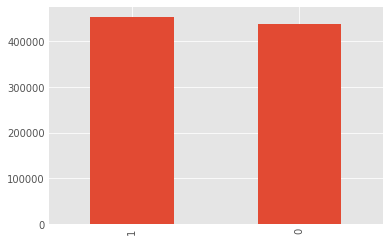

In [202]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

row_missing_df['full_or_missing'] = row_missing_data['feat_percent'].apply(lambda x:1 if x ==0 else 0)
row_missing_df['full_or_missing'].value_counts().plot(kind='bar')

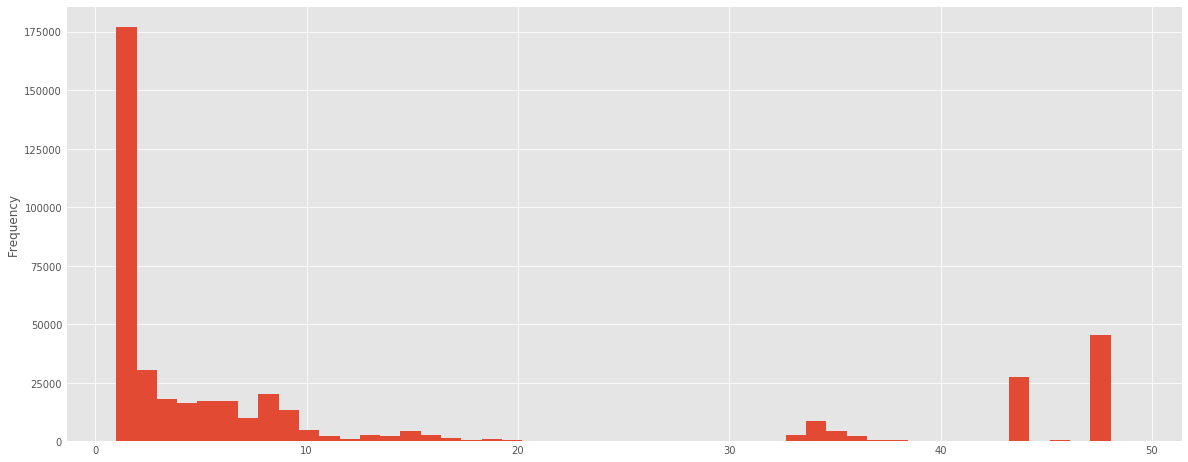

In [203]:
#Now look into records that are missing some data
row_missing_df['feat_count'][row_missing_df.full_or_missing == 0].plot(kind='hist',bins=50,figsize=(20,8))

In [204]:
#Subset 1 - Rows missing <= 10 features
azdias_subset_1 = azdias[row_missing_df['feat_count'] <= 10]

#Subset 2 - Rows missing > 10 features
azdias_subset_2 = azdias[row_missing_df['feat_count'] > 10]


In [97]:
azdias_subset_1.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,2.0,3,1,5,2,2,5,2,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


In [98]:
azdias_subset_2.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,2.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,3.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,2.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,2.0,2,4.0,4,3,1,4,5,1,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,4.0,1.0


In [99]:
#Subset 1 - Rows missing <= 10 features
print("Subset 1 has {}% of data and Subset 2 has {}%".format(round((azdias_subset_1.shape[0] / azdias.shape[0]) * 100,2) ,round((azdias_subset_2.shape[0] / azdias.shape[0]) * 100,2) ))

Subset 1 has 87.33% of data and Subset 2 has 12.67%


In [100]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

azdias_subset_1.isnull().sum().sort_values(ascending=False)

ALTER_HH                 223346
W_KEIT_KIND_HH            55402
KKK                       54308
REGIOTYP                  54308
LP_LEBENSPHASE_FEIN       44988
LP_LEBENSPHASE_GROB       42317
HEALTH_TYP                33663
SHOPPER_TYP               33663
VERS_TYP                  33663
NATIONALITAET_KZ          31043
LP_FAMILIE_GROB           27662
LP_FAMILIE_FEIN           27662
PRAEGENDE_JUGENDJAHRE     25581
KBA05_GBZ                 24386
KBA05_ANTG1               24386
KBA05_ANTG2               24386
KBA05_ANTG3               24386
KBA05_ANTG4               24386
MOBI_REGIO                24386
PLZ8_GBZ                   7964
PLZ8_ANTG3                 7964
PLZ8_HHZ                   7964
PLZ8_BAUMAX                7964
PLZ8_ANTG1                 7964
PLZ8_ANTG2                 7964
PLZ8_ANTG4                 7964
ANZ_HAUSHALTE_AKTIV        5691
KBA13_ANZAHL_PKW           5574
RELAT_AB                   3967
ARBEIT                     3967
                          ...  
WOHNLAGE

In [101]:
azdias_subset_2.isnull().sum().sort_values()

ZABEOTYP                      0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
SEMIO_ERL                     0
SEMIO_KULT                    0
SEMIO_RAT                     0
SEMIO_KRIT                    0
SEMIO_DOM                     0
SEMIO_KAEM                    0
GREEN_AVANTGARDE              0
SEMIO_PFLICHT                 0
FINANZTYP                     0
FINANZ_HAUSBAUER              0
FINANZ_UNAUFFAELLIGER         0
FINANZ_ANLEGER                0
FINANZ_VORSORGER              0
FINANZ_SPARER                 0
FINANZ_MINIMALIST             0
SEMIO_TRADV                   0
ANREDE_KZ                     0
SEMIO_SOZ                     0
SEMIO_FAM                     0
ALTERSKATEGORIE_GROB        261
RETOURTYP_BK_S             1731
LP_STATUS_GROB             1731
LP_STATUS_FEIN             1731
GFK_URLAUBERTYP            1731
CJT_GESAMTTYP              1731
                          ...  
WOHNLAGE

Text(0.5,1,'Subset 2')

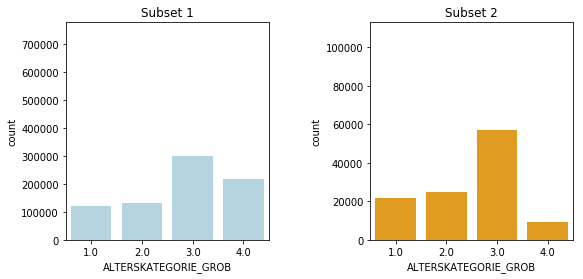

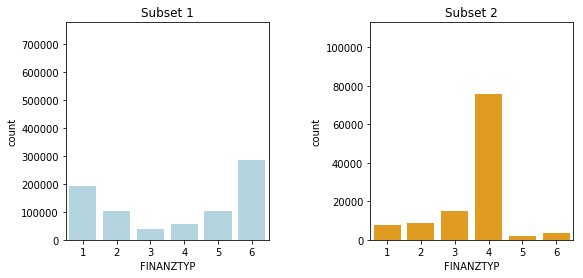

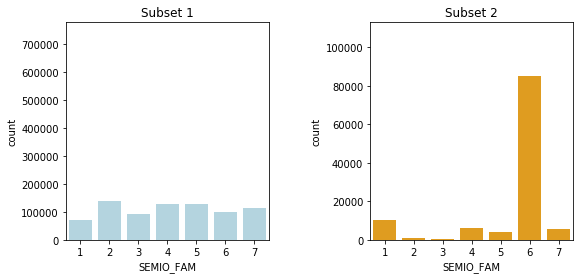

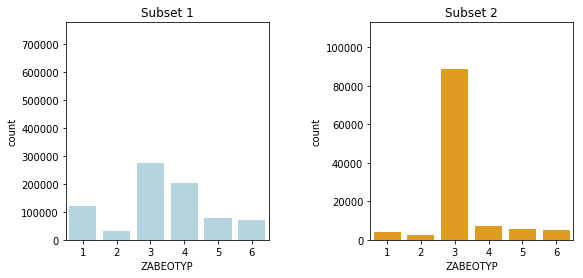

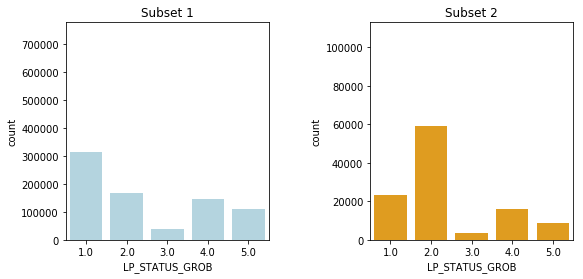

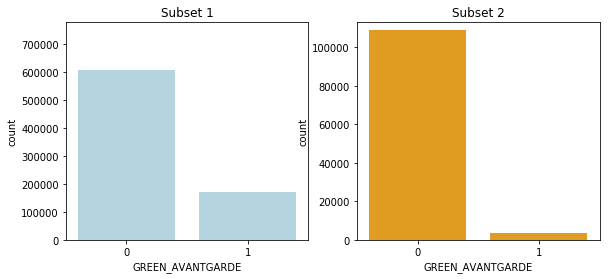

In [102]:
plt.figure(1,figsize=(20,4))

ylimit1 = azdias_subset_1.shape[0]
ylimit2 = azdias_subset_2.shape[0]

plt.subplot(141)
plt.ylim(0, ylimit1)
sns.countplot(x='ALTERSKATEGORIE_GROB',color='lightblue',data=azdias_subset_1)
plt.title("Subset 1")

plt.subplot(142)
plt.ylim(0, ylimit2)
sns.countplot(x='ALTERSKATEGORIE_GROB',color='orange',data=azdias_subset_2)
plt.title("Subset 2")

plt.subplots_adjust(wspace = 0.5)

plt.figure(2,figsize=(20,4))

plt.subplot(141)
plt.ylim(0, ylimit1)
sns.countplot(x='FINANZTYP',color='lightblue',data=azdias_subset_1)
plt.title("Subset 1")

plt.subplot(142)
plt.ylim(0, ylimit2)
sns.countplot(x='FINANZTYP',color='orange',data=azdias_subset_2)
plt.title("Subset 2")

plt.subplots_adjust(wspace = 0.5)

plt.figure(3,figsize=(20,4))

plt.subplot(141)
plt.ylim(0, ylimit1)
sns.countplot(x='SEMIO_FAM',color='lightblue',data=azdias_subset_1)
plt.title("Subset 1")

plt.subplot(142)
plt.ylim(0, ylimit2)
sns.countplot(x='SEMIO_FAM',color='orange',data=azdias_subset_2)
plt.title("Subset 2")

plt.subplots_adjust(wspace = 0.5)

plt.figure(4,figsize=(20,4))

plt.subplot(141)
plt.ylim(0, ylimit1)
sns.countplot(x='ZABEOTYP',color='lightblue',data=azdias_subset_1)
plt.title("Subset 1")

plt.subplot(142)
plt.ylim(0, ylimit2)
sns.countplot(x='ZABEOTYP',color='orange',data=azdias_subset_2)
plt.title("Subset 2")

plt.subplots_adjust(wspace = 0.5)

plt.figure(5,figsize=(20,4))

plt.subplot(141)
plt.ylim(0, ylimit1)
sns.countplot(x='LP_STATUS_GROB',color='lightblue',data=azdias_subset_1)
plt.title("Subset 1")

plt.subplot(142)
plt.ylim(0, ylimit2)
sns.countplot(x='LP_STATUS_GROB',color='orange',data=azdias_subset_2)
plt.title("Subset 2")


plt.subplots_adjust(wspace = 0.5)

plt.figure(6,figsize=(20,4))

plt.subplot(141)
plt.ylim(0, ylimit1)
sns.countplot(x='GREEN_AVANTGARDE',color='lightblue',data=azdias_subset_1)
plt.title("Subset 1")

plt.subplot(142)
plt.ylim(0, ylimit2)
sns.countplot(x='GREEN_AVANTGARDE',color='orange',data=azdias_subset_2)
plt.title("Subset 2")


In [103]:
# Checkpoint of azdias dataset taken
azdias_subset_1.to_csv('azdias_checkpoint_1.csv',sep=';',encoding='utf-8',index=False)

In [104]:
# Load from checkpoint
azdias2 = pd.read_csv('azdias_checkpoint_1.csv',sep=';')
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep=';')

#### Discussion 1.1.3: Assess Missing Data in Each Row

After dropping the columns, there are 453,092 points with complete data. This constitutes little over 50% of the data. 

Now, looking at records that are missing atleast 1 feature, it appears like at we can retain good chunk of the data if we can afford to miss data on 10 features. There was a contemplation on 9 or 10, there was close to 1% advantage with 10 over 9. This may not appear much but it's 89k records. I understand there may be a downside impact of this as clustering algorithms like k-means don't work well with missing data and we end up doing imputation which estimates the missing values thereby loosing the originality. However, I wanted to take the chance, have as much data as possible in hand and come back and change this if neccessary.

To compare the distributions of features between subset with no or few missing values and subset with remaining data, I manually chose combination of features that don't miss any values and some that miss few values. For example, ALTERSKATEGORIE_GROB has very few missing values but the shape of the data is very similar between both the subsets, hence it should not be a concern to get rid of subset 2 if looking at this feature. ZABEOTYP is an example where we dont have any missing values but since the distribution is similar between subsets, I think we are good to get rid of these records looking at this feature as well. However, LP_STATUS_GROB distributions are different between subsets but this also has higher number of missing values, I think we should be ok here as well.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [105]:
# How many features are there of each data type?
feat_info.type.value_counts()


ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [107]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
feat_info[feat_info.type == 'categorical']


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]


In [108]:
#Remove columns from feat_info that were discarded from azdias dataset

feat_info = feat_info[feat_info.attribute != 'TITEL_KZ']
feat_info = feat_info[feat_info.attribute != 'AGER_TYP']
feat_info = feat_info[feat_info.attribute != 'KK_KUNDENTYP']
feat_info = feat_info[feat_info.attribute != 'KBA05_BAUMAX']
feat_info = feat_info[feat_info.attribute != 'GEBURTSJAHR']


In [109]:
#Create a dataframe with just the categorical variables.
categorical_variables = azdias2[feat_info[feat_info['type'] == 'categorical']['attribute']]
categorical_variables

,ANREDE_KZ,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,GEBAEUDETYP,OST_WEST_KZ,CAMEO_DEUG_2015,CAMEO_DEU_2015
0,2,5.0,1,10.0,0,5.0,3.0,2.0,1.0,1.0,3.0,1.0,2.0,5,8.0,W,8.0,8A
1,2,3.0,1,10.0,1,1.0,1.0,3.0,2.0,1.0,2.0,0.0,1.0,5,1.0,W,4.0,4C
2,2,2.0,6,1.0,0,NaN,NaN,9.0,4.0,1.0,1.0,0.0,1.0,3,1.0,W,2.0,2A
3,1,5.0,5,5.0,0,10.0,5.0,3.0,2.0,1.0,2.0,0.0,2.0,4,1.0,W,6.0,6B
4,2,2.0,2,1.0,0,1.0,1.0,4.0,2.0,1.0,0.0,0.0,2.0,4,1.0,W,8.0,8C
5,2,5.0,4,12.0,0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,4,1.0,W,4.0,4A
6,1,3.0,5,9.0,0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1,8.0,W,2.0,2D
7,1,3.0,6,3.0,1,1.0,1.0,10.0,5.0,1.0,3.0,0.0,2.0,6,3.0,W,1.0,1A
8,2,4.0,1,12.0,1,1.0,1.0,3.0,2.0,1.0,3.0,0.0,2.0,4,3.0,W,1.0,1E
9,2,1.0,6,8.0,0,1.0,1.0,1.0,1.0,1.0,2.0,0.0,2.0,3,1.0,W,9.0,9D


In [49]:
len(categorical_variables.SOHO_KZ.value_counts())

2

In [110]:
categorical_variables.SOHO_KZ.value_counts()

0.0    771818
1.0      6527
Name: SOHO_KZ, dtype: int64

In [111]:
#For categrical variables, Identify binary vs multivar variables
binaryvar = []
multivar = []

for col in categorical_variables:
    
    if len(categorical_variables[col].value_counts()) == 2:
        
        binaryvar.append(col)
    elif len(categorical_variables[col].value_counts()) > 2:
        multivar.append(col)
        
        
    

In [112]:
binaryvar

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

In [113]:
multivar

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [114]:
# Re-encode categorical variable(s) to be kept in the analysis.

#Check binary categorical variables and convert non-numeric to numeric

azdias2['OST_WEST_KZ'].unique()
azdias2['OST_WEST_KZ'] = azdias2['OST_WEST_KZ'].map({'W': 1, 'O': 0})

In [115]:
#Check multivar features to determine which one's can be dropped and which one's to be re-encoded

#LP_FAMILIE_GROB - can be dropped. LP_FAMILIE_FEIN captures this info
#LP_STATUS_GROB - can be dropped. LP_STATUS_FEIN captures this info
#CAMEO_DEU_2015 - can be dropped. unnecessarily complicated and does not seem to add value for segmentation

cat_cols_drop = ['LP_FAMILIE_GROB','LP_STATUS_GROB','CAMEO_DEU_2015']
azdias2 = azdias2.drop(cat_cols_drop,axis=1)

In [116]:
#Simplify other categorical variables where possible
azdias2['GEBAEUDETYP'] = azdias2['GEBAEUDETYP'].map({1:1,2:1,3:2,4:2,5:2,6:2,7:2,8:2})

In [119]:
#Hot encode the remaining category variables.
multivar = [x for x in multivar if x not in cat_cols_drop]

In [122]:
azdias2 = pd.get_dummies(azdias2, columns = multivar, prefix=multivar)

In [123]:
azdias2.shape

(778345, 136)

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

After cleaning up the dataset for null values, the next step involved preparing the data based on the type of the variables and also encoding it to make it clustering algorithms friendly.

To do this, I first seperated categorical features from binary features. With binary features, the one hot encoding was not necessary but needed converting non-numeric values into numeric ones. I decided to keep all the binary features as they seemed releavent for the customer segmentation.

Then I analyzed the multi-category variables. The following categories ("CJT_GESAMTTYP", "FINANZTYP", "NATIONALITAET_KZ", "SHOPPER_TYP","ZABEOTYP") all related to person-level features without being too detailed so the decision was to keep them and one hot encode them.

For "LP_FAMILIE_FEIN","LP_FAMILIE_GROB","LP_STATUS_FEIN", and "LP_STATUS_GROB', the decision was to drop the Grobs which were summaries of the Feins. I thought the level of segregation was better for identifying customer segments in the more detailed Fein scales but it was unnecessary to keep both.

Between "CAMEO_DEUG_2015", and "CAMEO_DEU_2015", which both relate to wealth/life stage typology with the first using a rough scale and the second a very detailed marketing scale. I decided to keep only the rough scale. When you look through all the categories in the feature info list, the majority are at a higher level in detail to "CAMEO_DEU_2015". "CAMEO_DEU_2015" seems to be a level of detail too high for this particular customer segment analysis.


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [127]:
azdias2['PRAEGENDE_JUGENDJAHRE'].value_counts(dropna=False).sort_index()

 1.0      20225
 2.0       7434
 3.0      53038
 4.0      20323
 5.0      83508
 6.0      25476
 7.0       3956
 8.0     138456
 9.0      33153
 10.0     83784
 11.0     34610
 12.0     24004
 13.0      5552
 14.0    178261
 15.0     40984
NaN       25581
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [131]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# Engineer a column "mainstream" 
mainstream = []

for x in azdias2['PRAEGENDE_JUGENDJAHRE']:
    if x in [1,3,5,8,10,12,14]:
        mainstream.append(1) # 1 represents 'Mainstream'
    elif x in [2,4,6,7,9,11,13,15]:
        mainstream.append(0) # 0 represents 'Avantgarde'
    else:
        mainstream.append(np.nan)

In [132]:
a = pd.Series(mainstream)
azdias2['MAINSTREAM'] = a.values
azdias2.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_1.0,CAMEO_DEUG_2015_2.0,CAMEO_DEUG_2015_3.0,CAMEO_DEUG_2015_4.0,CAMEO_DEUG_2015_5.0,CAMEO_DEUG_2015_6.0,CAMEO_DEUG_2015_7.0,CAMEO_DEUG_2015_8.0,CAMEO_DEUG_2015_9.0,MAINSTREAM
0,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,0,0,0,0,0,1,0,1.0
1,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,1,0,0,0,0,0,0.0
2,4.0,2,4,2,5,2,1,2,0,2.0,...,0,1,0,0,0,0,0,0,0,1.0
3,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,1,0,0,0,1.0
4,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,0,0,0,0,0,1,0,1.0


In [133]:
azdias2.MAINSTREAM.value_counts()

1.0    581276
0.0    171488
Name: MAINSTREAM, dtype: int64

In [137]:
#Engineer variable for Decade
azdias2['DECADE'] = azdias2['PRAEGENDE_JUGENDJAHRE'].map({1:1,2:1,3:2,4:2,5:3,6:3,7:3,8:4,9:4,10:5,11:5,12:5,13:5,14:6,15:6})

In [138]:
azdias2['DECADE'].value_counts().sort_index()

1.0     27659
2.0     73361
3.0    112940
4.0    171609
5.0    147950
6.0    219245
Name: DECADE, dtype: int64

In [139]:
#Now, we can drop the original column from the dataframe
azdias2 = azdias2.drop('PRAEGENDE_JUGENDJAHRE',axis=1)

In [142]:
azdias2.head(10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_2.0,CAMEO_DEUG_2015_3.0,CAMEO_DEUG_2015_4.0,CAMEO_DEUG_2015_5.0,CAMEO_DEUG_2015_6.0,CAMEO_DEUG_2015_7.0,CAMEO_DEUG_2015_8.0,CAMEO_DEUG_2015_9.0,MAINSTREAM,DECADE
0,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,0,0,0,0,1,0,1.0,6.0
1,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,1,0,0,0,0,0,0.0,6.0
2,4.0,2,4,2,5,2,1,2,0,2.0,...,1,0,0,0,0,0,0,0,1.0,4.0
3,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,1,0,0,0,1.0,4.0
4,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,0,0,0,0,1,0,1.0,2.0
5,2.0,2,1,5,1,5,4,3,0,2.0,...,0,0,1,0,0,0,0,0,1.0,5.0
6,1.0,1,3,3,4,1,3,2,0,1.0,...,1,0,0,0,0,0,0,0,1.0,4.0
7,3.0,1,4,4,2,4,2,2,1,3.0,...,0,0,0,0,0,0,0,0,0.0,5.0
8,3.0,2,2,4,2,3,5,4,1,2.0,...,0,0,0,0,0,0,0,0,0.0,6.0
9,3.0,2,2,2,5,3,1,5,0,2.0,...,0,0,0,0,0,0,0,1,1.0,2.0


In [143]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

azdias2['CAMEO_INTL_2015'].value_counts()

51.0    132585
41.0     90848
24.0     89028
14.0     61322
43.0     55711
54.0     44909
25.0     38780
22.0     32150
45.0     25728
13.0     25603
23.0     24223
55.0     23547
52.0     20326
34.0     18193
31.0     17793
15.0     16711
44.0     14558
12.0     12856
35.0     10189
32.0     10130
33.0      9613
Name: CAMEO_INTL_2015, dtype: int64

In [144]:
cameo_wealth = []

for x in azdias2['CAMEO_INTL_2015']:
    if 10 < x < 16:
        cameo_wealth.append(5)
    elif 20 < x < 26:
        cameo_wealth.append(4)
    elif 30 < x < 36:
        cameo_wealth.append(3)
    elif 40 < x < 46:
        cameo_wealth.append(2)
    elif 50 < x < 56:
        cameo_wealth.append(1)
    else:
        cameo_wealth.append(np.nan)

In [145]:
azdias2['CAMEO_WEALTH'] = pd.Series(cameo_wealth).values

In [146]:
azdias2['CAMEO_WEALTH'].value_counts()

1.0    221367
2.0    186845
4.0    184181
5.0    116492
3.0     65918
Name: CAMEO_WEALTH, dtype: int64

In [147]:
cameo_lifestage = []

for x in azdias2['CAMEO_INTL_2015']:
    if x % 10 == 1:
        cameo_lifestage.append(1)
    elif x % 10 == 2:
        cameo_lifestage.append(2)
    elif x % 10 == 3:
        cameo_lifestage.append(3)
    elif x % 10 == 4:
        cameo_lifestage.append(4)
    elif x % 10 == 5:
        cameo_lifestage.append(5)
    else:
        cameo_lifestage.append(np.nan)

In [148]:
azdias2['CAMEO_LIFESTAGE'] = pd.Series(cameo_lifestage).values

In [149]:
# Remove original column
azdias2 = azdias2.drop(['CAMEO_INTL_2015'],axis=1)

In [150]:
azdias2.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_4.0,CAMEO_DEUG_2015_5.0,CAMEO_DEUG_2015_6.0,CAMEO_DEUG_2015_7.0,CAMEO_DEUG_2015_8.0,CAMEO_DEUG_2015_9.0,MAINSTREAM,DECADE,CAMEO_WEALTH,CAMEO_LIFESTAGE
0,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,0,0,1,0,1.0,6.0,1.0,1.0
1,3.0,2,1,4,1,2,3,5,1,3.0,...,1,0,0,0,0,0,0.0,6.0,4.0,4.0
2,4.0,2,4,2,5,2,1,2,0,2.0,...,0,0,0,0,0,0,1.0,4.0,5.0,2.0
3,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,1,0,0,0,1.0,4.0,2.0,3.0
4,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,0,0,1,0,1.0,2.0,1.0,4.0


In [151]:
azdias2['WOHNLAGE'].value_counts().sort_index()

0.0      2947
1.0     43116
2.0     98589
3.0    245652
4.0    133695
5.0     72646
7.0    166733
8.0     14967
Name: WOHNLAGE, dtype: int64

In [152]:
# Engineer a feature based on rural or not
azdias2['RURAL'] = azdias2['WOHNLAGE'].map({0:0,1:0,2:0,3:0,4:0,5:0,7:1,8:1})

In [154]:
# Engineer a feature based on quality of neighborhood
azdias2['NBRHOODQUALITY'] = azdias2['WOHNLAGE'].map({0:0,1:1,2:2,3:3,4:4,5:5,7:0,8:0})

In [155]:
# Drop mixed features not required
azdias2 = azdias2.drop(['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','WOHNLAGE','PLZ8_BAUMAX'],axis=1)

In [156]:
azdias2.shape

(778345, 136)

#### Discussion 1.2.2: Engineer Mixed-Type Features

The 2 variables "PRAEGENDE_JUGENDJAHRE" and "CAMEO_INTL_2015" were re-engineered into 4 new features as required at the start of this section. ("AVANTGARDE", "DEKADE", "CAMEO_WEALTH" and "CAMEO_LIFESTAGE")

For other mixed-type features ('LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB') were dropped on the basis that the information in these features were already included in other features in the dataset, 1.2 "ALTERSKATEGORIE_GROB", 1.13 "LP_FAMILIE_FEIN" and 1.15 "LP_STATUS_FEIN" and it wasn't necessary to re-engineer and keep them in the dataset.

For "KBA05_BAUMAX", again this feature was a summary of other features in the RR3 micro-cell category and was deemed unnecessary to re-engineer and keep.

However, for the last feature, 'WOHNLAGE', I thought the quality of the neighborhood could impact customer segments and this information wasn't available in other features, I re-engineered "WOHNLAGE" into 2 features, the first a binary categorical feature, whether the neighbourhood was rural or not, and the second into a rating class for the neighborhood. For rural neighborhoods I classed them as no score calculated.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [158]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
#Remove MIN_GEBAEUDEJAHR as this does not seem to be relevant in our customer segmentation model
azdias2 = azdias2.drop('MIN_GEBAEUDEJAHR',axis=1)

In [164]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

#Review all the features in the final dataframe
azdias2.iloc[0]

ALTERSKATEGORIE_GROB     1.0
ANREDE_KZ                2.0
FINANZ_MINIMALIST        1.0
FINANZ_SPARER            5.0
FINANZ_VORSORGER         2.0
FINANZ_ANLEGER           5.0
FINANZ_UNAUFFAELLIGER    4.0
FINANZ_HAUSBAUER         5.0
GREEN_AVANTGARDE         0.0
HEALTH_TYP               3.0
RETOURTYP_BK_S           1.0
SEMIO_SOZ                5.0
SEMIO_FAM                4.0
SEMIO_REL                4.0
SEMIO_MAT                3.0
SEMIO_VERT               1.0
SEMIO_LUST               2.0
SEMIO_ERL                2.0
SEMIO_KULT               3.0
SEMIO_RAT                6.0
SEMIO_KRIT               4.0
SEMIO_DOM                7.0
SEMIO_KAEM               4.0
SEMIO_PFLICHT            7.0
SEMIO_TRADV              6.0
SOHO_KZ                  1.0
VERS_TYP                 2.0
ALTER_HH                 NaN
ANZ_PERSONEN             2.0
ANZ_TITEL                0.0
                        ... 
NATIONALITAET_KZ_1.0     1.0
NATIONALITAET_KZ_2.0     0.0
NATIONALITAET_KZ_3.0     0.0
SHOPPER_TYP_0.

In [165]:
#Let's create the second checkpoint
azdias2.to_csv('azdias_checkpoint_2.csv',sep=';',encoding='utf-8',index=False)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [149]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...


    for feature in range(feat_info.shape[0]):

        col = feat_info.attribute[feature]
        col_miss = feat_info.missing_or_unknown[feature].split(",")

        col_codes=[]
    
        for elems in col_miss:

            v = re.sub('[^-0-9a-zA-Z{1,2}]+','',elems)

            if is_int(v):

                col_codes.append(int(v))
            else:

                col_codes.append(v)


        #print('col_codes = {}'.format(col_codes))

        df[col] = df[col].replace(col_codes,np.nan)


    # remove selected columns and rows, ...

    #dropping columns that are missing more than 50% of the values.	
    drop_columns = ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR']
    df = df.drop(drop_columns, axis=1)

    #Handle rows based on number of features missing data
    row_missing_data = {'feat_count':df.isnull().sum(axis=1),'feat_percent':(df.isnull().sum(axis=1)/df.shape[1] ) * 100}
    row_missing_df = pd.DataFrame(data=row_missing_data)
    
    df = df[row_missing_df['feat_count'] <= 10]
    
    # select, re-encode, and engineer column values.
    
    #Check binary categorical variables and convert non-numeric to numeric
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map({'W': 1, 'O': 0})

    #Check multivar features to determine which one's can be dropped and which one's to be re-encoded
    cat_cols_drop = ['LP_FAMILIE_GROB','LP_STATUS_GROB','CAMEO_DEU_2015']
    df = df.drop(cat_cols_drop,axis=1)

    #Simplify other categorical variables where possible
    df['GEBAEUDETYP'] = df['GEBAEUDETYP'].map({1:1,2:1,3:2,4:2,5:2,6:2,7:2,8:2})
    
    multivar = ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN',
                'NATIONALITAET_KZ','SHOPPER_TYP','ZABEOTYP','GEBAEUDETYP','CAMEO_DEUG_2015']
    
    #Hot encode the remaining category variables.
    df = pd.get_dummies(df, columns = multivar, prefix=multivar)
    
    # Engineer a column "mainstream" 
    mainstream = []

    for x in df['PRAEGENDE_JUGENDJAHRE']:
        if x in [1,3,5,8,10,12,14]:
            mainstream.append(1) # 1 represents 'Mainstream'
        elif x in [2,4,6,7,9,11,13,15]:
            mainstream.append(0) # 0 represents 'Avantgarde'
        else:
            mainstream.append(np.nan)

    df['MAINSTREAM'] = pd.Series(mainstream).values

    #Engineer variable for Decade
    df['DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].map({1:1,2:1,3:2,4:2,5:3,6:3,7:3,8:4,9:4,10:5,11:5,12:5,13:5,14:6,15:6})

    df = df.drop('PRAEGENDE_JUGENDJAHRE',axis=1)

    cameo_wealth = []

    for x in df['CAMEO_INTL_2015']:
        x = float(x)
        if 10 < x < 16:
            cameo_wealth.append(5)
        elif 20 < x < 26:
            cameo_wealth.append(4)
        elif 30 < x < 36:
            cameo_wealth.append(3)
        elif 40 < x < 46:
            cameo_wealth.append(2)
        elif 50 < x < 56:
            cameo_wealth.append(1)
        else:
            cameo_wealth.append(np.nan)

    df['CAMEO_WEALTH'] = pd.Series(cameo_wealth).values

    cameo_lifestage = []

    for x in df['CAMEO_INTL_2015']:
        x = float(x)
        if x % 10 == 1:
            cameo_lifestage.append(1)
        elif x % 10 == 2:
            cameo_lifestage.append(2)
        elif x % 10 == 3:
            cameo_lifestage.append(3)
        elif x % 10 == 4:
            cameo_lifestage.append(4)
        elif x % 10 == 5:
            cameo_lifestage.append(5)
        else:
            cameo_lifestage.append(np.nan)

    df['CAMEO_LIFESTAGE'] = pd.Series(cameo_lifestage).values

    # Engineer a feature based on rural or not
    df['RURAL'] = df['WOHNLAGE'].map({0:0,1:0,2:0,3:0,4:0,5:0,7:1,8:1})

    # Engineer a feature based on quality of neighborhood
    df['NBRHOODQUALITY'] = df['WOHNLAGE'].map({0:0,1:1,2:2,3:3,4:4,5:5,7:0,8:0})

    # Drop mixed features not required
    df = df.drop(['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','WOHNLAGE','PLZ8_BAUMAX','MIN_GEBAEUDEJAHR','CAMEO_INTL_2015'],axis=1)

    
    # Return the cleaned dataframe.
    
    return df

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [2]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

azdias3 = pd.read_csv('azdias_checkpoint_2.csv',sep=';')

In [16]:
azdias3.shape

(778345, 135)

In [18]:
#See how many columns are missing values and % of data missing
((azdias3.isnull().sum()[azdias3.isnull().sum() != 0] / azdias3.shape[0]) * 100).sort_index()

ALTERSKATEGORIE_GROB     0.336612
ALTER_HH                28.694987
ANZ_HAUSHALTE_AKTIV      0.731167
ANZ_HH_TITEL             0.410743
ARBEIT                   0.509671
BALLRAUM                 0.068607
CAMEO_LIFESTAGE          0.455068
CAMEO_WEALTH             0.455068
DECADE                   3.286589
EWDICHTE                 0.068607
GEBAEUDETYP_RASTER       0.000642
HEALTH_TYP               4.324946
INNENSTADT               0.068607
KBA05_ANTG1              3.133058
KBA05_ANTG2              3.133058
KBA05_ANTG3              3.133058
KBA05_ANTG4              3.133058
KBA05_GBZ                3.133058
KBA13_ANZAHL_PKW         0.716135
KKK                      6.977369
KONSUMNAEHE              0.006552
MAINSTREAM               3.286589
MOBI_REGIO               3.133058
ONLINE_AFFINITAET        0.401236
ORTSGR_KLS9              0.497980
PLZ8_ANTG1               1.023197
PLZ8_ANTG2               1.023197
PLZ8_ANTG3               1.023197
PLZ8_ANTG4               1.023197
PLZ8_GBZ      

In [3]:
columns_list = list(azdias3.columns.values)

In [4]:
# Impute nans using mode value
impute = Imputer(missing_values='NaN',strategy='most_frequent',axis=0)
azdias3 = impute.fit_transform(azdias3)
azdias3 = pd.DataFrame(azdias3)
azdias3.head()

,0,1,2,3,4,5,6,7,8,9,...,125,126,127,128,129,130,131,132,133,134
0,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,0.0,0.0,1.0,0.0,1.0,6.0,1.0,1.0,0.0,4.0
1,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,6.0,4.0,4.0,0.0,2.0
2,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,...,0.0,0.0,0.0,0.0,1.0,4.0,5.0,2.0,1.0,0.0
3,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,1.0,0.0,0.0,0.0,1.0,4.0,2.0,3.0,0.0,3.0
4,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,...,0.0,0.0,1.0,0.0,1.0,2.0,1.0,4.0,1.0,0.0


In [5]:
# Apply feature scaling to the general population demographics data.

scaler = StandardScaler()
azdias3 = scaler.fit_transform(azdias3)
azdias3 = pd.DataFrame(azdias3,columns=columns_list)
azdias3.head()


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_6.0,CAMEO_DEUG_2015_7.0,CAMEO_DEUG_2015_8.0,CAMEO_DEUG_2015_9.0,MAINSTREAM,DECADE,CAMEO_WEALTH,CAMEO_LIFESTAGE,RURAL,NBRHOODQUALITY
0,-1.766408,0.958685,-1.489955,1.541097,-1.045424,1.469493,0.981614,1.327790,-0.531586,1.007301,...,-0.392992,-0.330396,2.201677,-0.399295,0.531586,1.106416,-1.171211,-1.250086,-0.551848,0.971774
1,0.198349,0.958685,-1.489955,0.868230,-1.771562,-0.567989,0.263850,1.327790,1.881163,1.007301,...,-0.392992,-0.330396,-0.454199,-0.399295,-1.881163,1.106416,0.873984,0.763553,-0.551848,-0.250039
2,1.180727,0.958685,0.688074,-0.477504,1.132989,-0.567989,-1.171678,-0.817198,-0.531586,-0.315171,...,-0.392992,-0.330396,-0.454199,-0.399295,0.531586,-0.258655,1.555716,-0.578873,1.812093,-1.471851
3,0.198349,-1.043095,0.688074,0.195363,0.406851,-1.247150,0.263850,-0.817198,-0.531586,1.007301,...,2.544580,-0.330396,-0.454199,-0.399295,0.531586,-0.258655,-0.489479,0.092340,-0.551848,0.360867
4,-1.766408,0.958685,-0.037935,-1.150371,1.132989,-0.567989,-0.453914,1.327790,-0.531586,1.007301,...,-0.392992,-0.330396,2.201677,-0.399295,0.531586,-1.623726,-1.171211,0.763553,1.812093,-1.471851


### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

I wanted to assess if removing null alues prior to scale and then impute with removed null values was necessary in this case. Looking at the columns, there are 36 columns that are missing atleast some data but when I saw the % of missing data, ost of the columns were missing .1 - 2% of the data, very few were around 6 - % and only one column was missing 28% of the data. As a first pass, I didn't think there was any need to go the complex route for scaling and impuatation.

Then for imputation, I chose the 'most_frequent' method as most of the data we are dealing with is categorical in nature and any other method such as mean or media did not make sense.

For Scaling, I used the StandardScaler as suggested.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [7]:
# Apply PCA to the data.
def do_pca(n_components,data):
    '''
    Transforms data using PCA to create n_components and provides back the results of the transformation
    INPUT:  n_components - int - the number of principal components to create
            data - the data you would like to transform
    OUTPUT: pca - the pca object created after fitting the data
            X_pca - the transformed X matrix with new number of components
    '''
    #X = StandardScaler().fit_transform(data)
    X = data
    pca = PCA(n_components,whiten=True,random_state=42)
    X_pca = pca.fit_transform(X)
    return pca, X_pca


In [8]:
pca, azdias3_pca = do_pca(70,azdias3)

In [9]:
azdias3_pca = pd.DataFrame(azdias3_pca)

In [10]:
azdias3_pca.shape

(778345, 70)

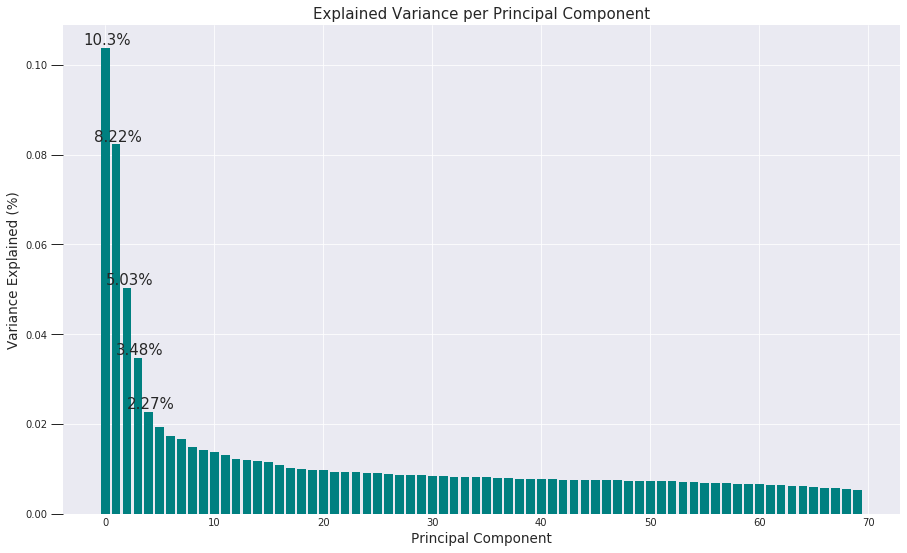

In [11]:
# Investigate the variance accounted for by each principal component.

def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components
    INPUT: pca - the result of instantian of PCA in scikit learn
    OUTPUT: none
    '''
    sns.set_style("darkgrid")
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
    
    plt.figure(figsize=(15,9))
    ax = plt.subplot(111)
    plt.style.use("ggplot")
    
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals,color='teal')
    for i in range(0,ind[5]):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2,vals[i]), va='bottom',ha='center',fontsize=15)
        
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=1,length=12)
    
    ax.set_xlabel("Principal Component",fontsize=13.5)
    ax.set_ylabel("Variance Explained (%)",fontsize=13.5)
    plt.title("Explained Variance per Principal Component",fontsize=15)
    
    plt.show()
    
    
scree_plot(pca)

[ 0.10360931  0.18587093  0.23617282  0.27098324  0.29377622  0.31320556
  0.33058412  0.347282    0.36220871  0.37657625  0.39031882  0.40358207
  0.41585391  0.42785847  0.43981498  0.45138938  0.46234897  0.47268971
  0.48285838  0.49272034  0.50246373  0.51196073  0.52136745  0.53070365
  0.53990166  0.54901505  0.55788957  0.56669271  0.57540396  0.58410033
  0.5926703   0.60119359  0.60958266  0.61787308  0.62614686  0.63433732
  0.64250984  0.65061236  0.65857052  0.66646571  0.67434651  0.68216015
  0.68989383  0.6975974   0.70528399  0.71292928  0.72048921  0.72801612
  0.73550492  0.7429705   0.7504112   0.75777738  0.76510664  0.77237298
  0.77961031  0.78667748  0.79366493  0.80055724  0.80735829  0.81413823
  0.82086825  0.82745826  0.83396393  0.8403328   0.84656514  0.85262812
  0.85853827  0.86437362  0.86989227  0.87532106]


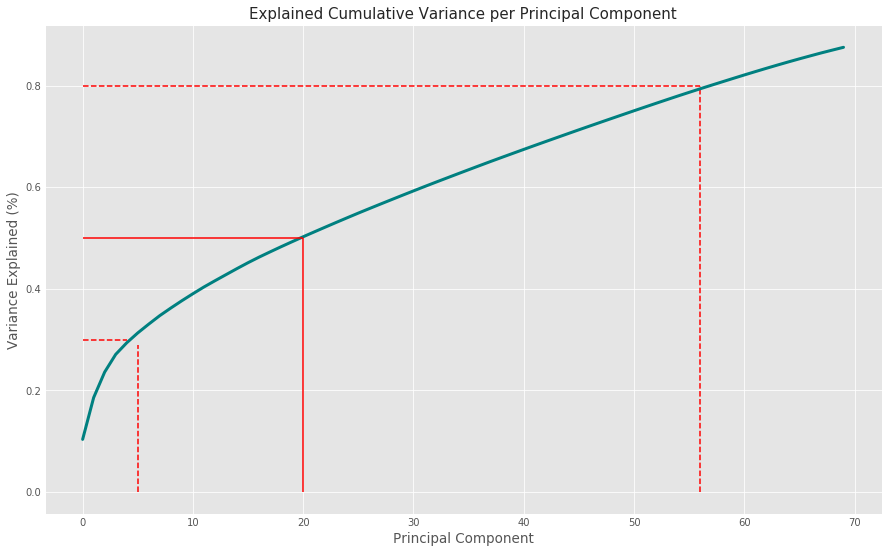

In [12]:
def scree_plot2(pca):
    '''
    Creates a scree plot associated with the principal components
    INPUT: pca - the result of instantian of PCA in scikit learn
    OUTPUT: none
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
    
    plt.figure(figsize=(15,9))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    
    ax.plot(ind, cumvals,color='teal',linewidth=3)
    plt.hlines(y=0.8, xmin=0, xmax=56, color='red', linestyles='dashed',zorder=1)
    plt.vlines(x=56, ymin=0, ymax=0.8, color='red', linestyles='dashed',zorder=2)
    plt.hlines(y=0.3, xmin=0, xmax=4, color='red', linestyles='dashed',zorder=3)
    plt.vlines(x=5, ymin=0, ymax=0.29, color='red', linestyles='dashed',zorder=4)
    plt.hlines(y=0.5, xmin=0, xmax=20, color='red', linestyles='-',zorder=5)
    plt.vlines(x=20, ymin=0, ymax=0.5, color='red', linestyles='-',zorder=6)
    
    ax.set_xlabel("Principal Component",fontsize=13.5)
    ax.set_ylabel("Variance Explained (%)",fontsize=13.5)
    plt.title("Explained Cumulative Variance per Principal Component",fontsize=15)
    
    print(cumvals)
    
scree_plot2(pca)

In [13]:
pca1 = pca.explained_variance_ratio_.tolist()
print(np.sum(pca1[:45]))

0.705283989333


In [14]:
# Re-apply PCA to the data while selecting for number of components to retain.

#I'll go with 45 components that roughly explains 70% variance
pca_2, azdias3_pca2 = do_pca(45,azdias3)

In [23]:
azdias3_pca2 = pd.DataFrame(azdias3_pca2)
azdias3_pca2.head()

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
0,1.358680,-0.900998,-1.083422,0.224492,-0.609579,1.753048,1.694266,-1.340283,0.332758,0.306285,...,0.137712,2.180257,3.923754,0.191087,1.139636,-2.970338,-4.413540,-2.964292,-0.129622,-0.019654
1,-0.066171,-0.212436,-1.227165,1.124493,-1.570780,-0.658164,0.119406,-0.450417,-0.137227,-1.012929,...,1.513356,-0.787280,-0.147104,0.304394,0.814884,-0.380195,1.596018,-0.789957,1.486152,1.118161
2,-1.341966,0.376735,-0.486478,-0.975038,-0.063219,-0.345140,-0.738393,0.433131,0.738626,0.371202,...,-1.431208,1.460977,-0.778996,-0.039652,1.559831,1.031725,1.831234,-0.298611,-0.431048,0.944013
3,0.077995,0.138610,1.239279,0.616341,1.799304,-1.381461,1.424267,-0.323662,-1.552282,-0.937481,...,0.127237,0.659725,-0.753080,0.285105,0.513291,0.450394,0.037896,-0.942071,0.209459,0.860896
4,-0.385724,-0.333146,-0.429699,-1.695082,-1.656071,-1.032632,1.172776,0.068199,-0.794618,2.046239,...,-2.166817,0.390088,0.622579,0.364372,2.295527,0.114553,0.544874,-0.442100,-1.248061,0.047298


In [119]:
#Save Checkpoint with PCA transformation
azdias3_pca2.to_csv('azdias_pca_checkpoint_3.csv',sep=';',encoding='utf-8',index=False)

### Discussion 2.2: Perform Dimensionality Reduction

Once my dataset was ready for PCA analysist, it had 135 features in it. As a first pass with PCA, I began with little over half the number of features, that is 0. Looked like a good number as almost all variance was explained by 0 components (nearly 97%).

From the cumulative variance chart, I saw that 80% of the variance is explained by 58 components and while I could go with this number I was looking for some balance between 50% variance and 80% variance to keep the model little simpler. Also, when I look at the components variance explainability after a certain point such as 20, the incremental value add was mere 1%. I could have stopped at 20% that explains 50% variance but that seemed too low and hence settled at 45 (70% explainability)

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [41]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

pca_2.components_

array([[ -1.13872122e-01,   1.08595933e-02,  -2.04323757e-01, ...,
         -1.12641872e-01,  -1.25773656e-01,   1.45031861e-01],
       [  2.18478221e-01,   4.13701423e-02,   6.20247024e-02, ...,
         -7.52411745e-03,  -7.27578608e-02,   6.89980729e-02],
       [  1.65483996e-02,  -3.49228715e-01,   1.32038216e-01, ...,
         -1.18593504e-02,  -4.54637977e-02,   3.80817016e-02],
       ..., 
       [  2.31080906e-02,  -1.18757113e-02,  -3.78667322e-02, ...,
          1.59628480e-02,   3.27882433e-02,  -1.04207501e-02],
       [  7.32296563e-05,   3.94084679e-03,   2.26769622e-02, ...,
          3.64911194e-02,  -3.42247068e-02,   3.20063811e-02],
       [  3.36129498e-02,   5.36630756e-03,   1.34224593e-03, ...,
          2.48539040e-02,  -2.48867820e-02,   2.40005669e-02]])

In [76]:
feat_weights = pd.DataFrame(pca_2.components_,columns=columns_list)
feat_weights.index = ['PC{}'.format(i) for i in feat_weights.index.values]


In [77]:
feat_weights.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_6.0,CAMEO_DEUG_2015_7.0,CAMEO_DEUG_2015_8.0,CAMEO_DEUG_2015_9.0,MAINSTREAM,DECADE,CAMEO_WEALTH,CAMEO_LIFESTAGE,RURAL,NBRHOODQUALITY
PC0,-0.113872,0.010860,-0.204324,0.144197,-0.112513,0.075909,0.080763,0.140099,-0.098205,0.039349,...,0.000122,0.033239,0.089383,0.113709,0.098205,0.108347,-0.180383,-0.112642,-0.125774,0.145032
PC1,0.218478,0.041370,0.062025,-0.210200,0.206296,-0.197954,-0.205957,0.104336,-0.018136,-0.049830,...,0.012567,0.015144,0.049180,0.035343,0.018136,-0.219954,-0.081835,-0.007524,-0.072758,0.068998
PC2,0.016548,-0.349229,0.132038,-0.057431,0.049148,-0.153372,-0.047271,-0.064528,0.069771,-0.015067,...,-0.004701,-0.000936,0.010265,0.018673,-0.069771,-0.057145,-0.015018,-0.011859,-0.045464,0.038082
PC3,-0.027467,0.077642,0.034824,0.002034,-0.014450,-0.081372,0.075132,-0.073620,0.325471,-0.002193,...,-0.031810,-0.021724,-0.030149,-0.031020,-0.325471,0.031256,0.101042,0.049630,-0.219442,0.124250
PC4,0.045105,-0.026642,0.084958,-0.020010,0.000335,0.047246,-0.109565,-0.102740,-0.078420,0.025200,...,-0.008528,-0.010893,0.048183,0.063931,0.078420,0.009145,-0.084857,-0.050134,-0.041492,0.087878


In [80]:
pc_ratios = pd.DataFrame(data =pca_2.explained_variance_ratio_,columns=['Ratio'],index=feat_weights.index.values)
pc_ratios.head()

,Ratio
PC0,0.103609
PC1,0.082262
PC2,0.050302
PC3,0.034810
PC4,0.022793


In [115]:
def get_pc_primary_features(pcamodel,pc,num_weights=5):
    
    feat_weights = pd.DataFrame(pcamodel.components_,columns=columns_list)
    feat_weights.index = ['PC{}'.format(i) for i in feat_weights.index.values]
    
    top_n = feat_weights.loc[pc].sort_values(ascending=False)[:num_weights]
    bottom_n = feat_weights.loc[pc].sort_values()[:num_weights]
    
    #print("PCA Model = {}".format(pcamodel))
    #print('\n')
    print("Top {} features for Principle component {} are:".format(num_weights,pc))
    print(top_n)
    print('='*50)
    print("Bottom {} features for Principle component {} are:".format(num_weights,pc))
    print(bottom_n)
    

In [116]:
get_pc_primary_features(pca_2,'PC0')

Top 5 features for Principle component PC0 are:
PLZ8_ANTG3            0.187631
HH_EINKOMMEN_SCORE    0.181268
PLZ8_ANTG4            0.180786
ORTSGR_KLS9           0.167121
EWDICHTE              0.163892
Name: PC0, dtype: float64
Bottom 5 features for Principle component PC0 are:
FINANZ_MINIMALIST   -0.204324
MOBI_REGIO          -0.195248
PLZ8_ANTG1          -0.186855
KBA05_ANTG1         -0.184946
KBA05_GBZ           -0.182531
Name: PC0, dtype: float64


In [117]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
get_pc_primary_features(pca_2,'PC1')


Top 5 features for Principle component PC1 are:
ALTERSKATEGORIE_GROB    0.218478
FINANZ_VORSORGER        0.206296
ZABEOTYP_3              0.194607
SEMIO_ERL               0.172155
RETOURTYP_BK_S          0.154830
Name: PC1, dtype: float64
Bottom 5 features for Principle component PC1 are:
DECADE                  -0.219954
FINANZ_SPARER           -0.210200
FINANZ_UNAUFFAELLIGER   -0.205957
SEMIO_REL               -0.202533
FINANZ_ANLEGER          -0.197954
Name: PC1, dtype: float64


In [118]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

get_pc_primary_features(pca_2,'PC2')

Top 5 features for Principle component PC2 are:
SEMIO_VERT     0.324145
SEMIO_FAM      0.262600
SEMIO_SOZ      0.259156
SEMIO_KULT     0.253282
FINANZTYP_5    0.135634
Name: PC2, dtype: float64
Bottom 5 features for Principle component PC2 are:
ANREDE_KZ    -0.349229
SEMIO_KAEM   -0.319989
SEMIO_DOM    -0.287325
SEMIO_KRIT   -0.268680
SEMIO_ERL    -0.208428
Name: PC2, dtype: float64


### Discussion 2.3: Interpret Principal Components

For component 1 the top 5 positive weights are: "PLZ8_ANTG3", number of 6-10 family homes in the PLZ8 region, "HH_EINKOMMEN_SCORE", Estimated household net income, "PLZ8_ANTG4", number of 10+ family houses in the PLZ8 region, "ORTSGR_KLS9", size of community, "EWDICHTE", density of households per km squared.

The top 5 negative weights are: "FINANZ_MINIMALIST", low financial interest, "MOBI_REGIO", movement patterns, "PLZ8_ANTG1", number of 1-2 family houses in PLZ8 region, "KBA05_ANTG1" number of 1-2 family houses in the microcell, "KBA05_GBZ", number of buildings in the microcell.

The first principal component seems to be representing a combination of features that relate to population density in an area and the associated wealth of that area. Positive correlations with increasing population density and wealth and negative correlations with low density and little financial interest features.

For component 2 the top 5 positive weights: "ALTERSKATEGORIE_GROB", estimated age based on given name analysis, "FINANZ_VORSORGER", financial typology is be prepared, "ZABEOTYP_3", energy consumption typology, "SEMIO_ERL", personality typology event-oriented, "RETOURTYP_BK_S", return shopper type.

And top 5 negative weights: "DEKADE", decade of youth, "FINANZ_SPARER", financial typology is money-saver, "SEMIO_REL", personality typology is religious, "FINANZ_UNAUFFAELLIGER", financial typology is inconspicuous, "SEMIO_TRADV", personality typology is traditional-minded.

The second principal component seems to be representing a combination of features related to individuals of older people with conservative traditional values. Positive correlations with increasing age and financial prudence.

For component 3, I have taken only the first 4 positive features as the fifth as a weight conspicuously lower than the fourth at 14% to 25%. The top weight "SEMIO_VERT", personality type dreamful, is also 6% higher than the second weight "SEMIO_FAM", personality type is family-minded, "SEMIO_SOZ", personality type is socially-minded, and "SEMIO_KULT", personality type is cultural-minded.

And the top 5 negative weights: "ANREDE_KZ" gender at -35%, "SEMIO_KAEM", personality typology is combative attitude, "SEMIO_DOM", personality typology is dominant-minded, "SEMIO_KRIT", personality typology is critical-minded, "SEMIO_ERL", personality typology is event-orientated.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [122]:
# Over a number of different cluster counts...

azdias4 = pd.read_csv('azdias_pca_checkpoint_3.csv',sep=';')
azdias4.head(2)
    # run k-means clustering on the data and...
    
    
    # compute the average within-cluster distances.
    
    

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
0,1.358680,-0.900998,-1.083422,0.224492,-0.609579,1.753048,1.694266,-1.340283,0.332758,0.306285,...,0.137712,2.180257,3.923754,0.191087,1.139636,-2.970338,-4.413540,-2.964292,-0.129622,-0.019654
1,-0.066171,-0.212436,-1.227165,1.124493,-1.570780,-0.658164,0.119406,-0.450417,-0.137227,-1.012929,...,1.513356,-0.787280,-0.147104,0.304394,0.814884,-0.380195,1.596018,-0.789957,1.486152,1.118161


In [123]:
# Function to calculate K-Means score for a centroid

def get_kmeans_score(data, center):
    
    kmeans = KMeans(n_clusters = center, n_init=10, max_iter=300, random_state=42)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    return score

In [127]:
score = []
centroids = [2,4,6,7,8,9,10,11,12,13,14,15,16,18,20,22,25,28,30]

for x in centroids:
    score.append(get_kmeans_score(azdias4,x))

In [134]:
cluster_score = {'cluster':centroids,'avg_dist':score}
cluster_score_df = pd.DataFrame(data=cluster_score)
cluster_score_df.avg_dist = cluster_score_df['avg_dist'].round(0)
cluster_score_df

,avg_dist,cluster
0,34307244.0,2
1,33023193.0,4
2,31738613.0,6
3,31427746.0,7
4,30818060.0,8
5,30546760.0,9
6,30058835.0,10
7,29738417.0,11
8,29244456.0,12
9,29023006.0,13


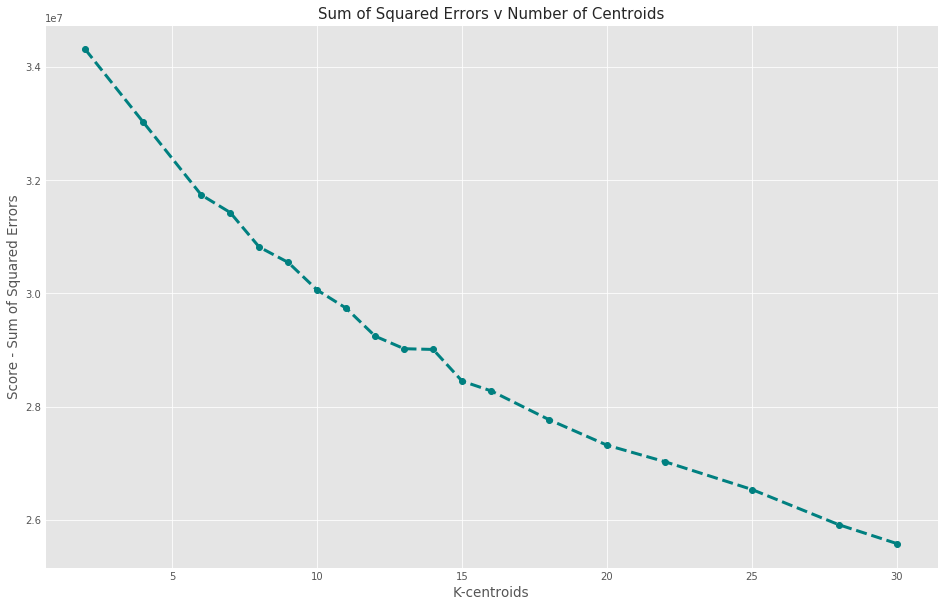

In [135]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
fig = plt.subplots(figsize=(16,10))
ax = plt.subplot(111)
plt.plot(centroids,score,linestyle='--',linewidth=3,marker='o',color='teal')

ax.set_xlabel('K-centroids', fontsize=13.5)
ax.set_ylabel('Score - Sum of Squared Errors', fontsize=13.5)
plt.title('Sum of Squared Errors v Number of Centroids',fontsize=15);


In [136]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans_15 = KMeans(n_clusters=15, n_init=10, max_iter=300, random_state=42)
population_clusters = kmeans_15.fit_predict(azdias4)

### Discussion 3.1: Apply Clustering to General Population

Ran the clustering on the PCA transformed data. I chose to run the model with clusters in the increments of 2 until 30. Got almost a straight line as you can see above. I think it could be due to my choice with number of principal components to go with. I chose to go with 45 principal components that explains 70% of the variance, thus requiring more clusters to segment the population properly. I'm not sure. It could be random as well as Kmeans can give me a different picture if I run it again as it starts by randomply placing the centroids and then forming the clusters. I did not run it again as this step took really long to complete.

However, with the clusters I got, at cluster 13, it appeared to form a elbow but imediately after 14, there's a steep jump to cluster 15. I chose 15 as number of clusters to go ahead with. 

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [137]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',sep=';')

In [138]:
customers.shape

(191652, 85)

In [150]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# Apply population data wrangling to customer dataframe
customers_clean = clean_data(customers)

In [151]:
customers_clean.shape

(138454, 135)

In [152]:
customers_clean.head(10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,MAINSTREAM,DECADE,CAMEO_WEALTH,CAMEO_LIFESTAGE,RURAL,NBRHOODQUALITY
0,4.0,1,5,1,5,1,2,2,1,1.0,...,0,0,0,0,0.0,2.0,5.0,3.0,1,0
2,4.0,2,5,1,5,1,4,4,1,2.0,...,0,0,0,0,0.0,2.0,3.0,4.0,0,2
3,4.0,1,5,1,5,2,1,2,0,2.0,...,0,0,0,0,1.0,1.0,4.0,4.0,1,0
4,3.0,1,3,1,4,4,5,2,0,3.0,...,0,1,0,0,1.0,4.0,2.0,1.0,0,3
5,3.0,1,5,1,5,1,2,3,1,3.0,...,0,0,0,0,0.0,2.0,3.0,4.0,0,1
6,4.0,1,5,1,5,1,1,2,1,2.0,...,0,0,0,0,0.0,2.0,4.0,3.0,1,0
7,4.0,1,5,1,5,1,2,2,1,1.0,...,0,0,0,0,0.0,2.0,5.0,5.0,0,3
8,4.0,2,2,2,5,1,1,5,0,2.0,...,0,0,0,1,1.0,1.0,1.0,5.0,0,4
9,3.0,1,5,2,4,1,3,1,1,3.0,...,0,0,0,0,0.0,4.0,5.0,5.0,0,5
11,4.0,1,5,1,5,1,3,2,1,1.0,...,0,0,0,0,0.0,2.0,5.0,4.0,0,4


In [153]:
cust_column_list = list(customers_clean.columns.values)
cust_column_list

['ALTERSKATEGORIE_GROB',
 'ANREDE_KZ',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'GREEN_AVANTGARDE',
 'HEALTH_TYP',
 'RETOURTYP_BK_S',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'SOHO_KZ',
 'VERS_TYP',
 'ALTER_HH',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'HH_EINKOMMEN_SCORE',
 'W_KEIT_KIND_HH',
 'WOHNDAUER_2008',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'KONSUMNAEHE',
 'OST_WEST_KZ',
 'KBA05_ANTG1',
 'KBA05_ANTG2',
 'KBA05_ANTG3',
 'KBA05_ANTG4',
 'KBA05_GBZ',
 'BALLRAUM',
 'EWDICHTE',
 'INNENSTADT',
 'GEBAEUDETYP_RASTER',
 'KKK',
 'MOBI_REGIO',
 'ONLINE_AFFINITAET',
 'REGIOTYP',
 'KBA13_ANZAHL_PKW',
 'PLZ8_ANTG1',
 'PLZ8_ANTG2',
 'PLZ8_ANTG3',
 'PLZ8_ANTG4',
 'PLZ8_HHZ',
 'PLZ8_GBZ',
 'ARBEIT',
 'ORTSGR_KLS9',
 'RELAT_AB',
 'CJT_GESAMTTYP_1.0',


In [154]:
# Impute the customer data using population imputer object
customers_clean = impute.transform(customers_clean)
customers_clean = pd.DataFrame(customers_clean)
customers_clean.head()

,0,1,2,3,4,5,6,7,8,9,...,125,126,127,128,129,130,131,132,133,134
0,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,2.0,5.0,3.0,1.0,0.0
1,4.0,2.0,5.0,1.0,5.0,1.0,4.0,4.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,2.0,3.0,4.0,0.0,2.0
2,4.0,1.0,5.0,1.0,5.0,2.0,1.0,2.0,0.0,2.0,...,0.0,0.0,0.0,0.0,1.0,1.0,4.0,4.0,1.0,0.0
3,3.0,1.0,3.0,1.0,4.0,4.0,5.0,2.0,0.0,3.0,...,0.0,1.0,0.0,0.0,1.0,4.0,2.0,1.0,0.0,3.0
4,3.0,1.0,5.0,1.0,5.0,1.0,2.0,3.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,2.0,3.0,4.0,0.0,1.0


In [155]:
customers_clean.isnull().any().sum()

0

In [156]:
# Apply population scaler to transform customer dataframe
customers_clean = scaler.transform(customers_clean)
customers_clean = pd.DataFrame(customers_clean)
customers_clean.head()

,0,1,2,3,4,5,6,7,8,9,...,125,126,127,128,129,130,131,132,133,134
0,1.180727,-1.043095,1.414084,-1.150371,1.132989,-1.247150,-0.453914,-0.817198,1.881163,-1.637644,...,-0.392992,-0.330396,-0.454199,-0.399295,-1.881163,-1.623726,1.555716,0.092340,1.812093,-1.471851
1,1.180727,0.958685,1.414084,-1.150371,1.132989,-1.247150,0.981614,0.612794,1.881163,-0.315171,...,-0.392992,-0.330396,-0.454199,-0.399295,-1.881163,-1.623726,0.192253,0.763553,-0.551848,-0.250039
2,1.180727,-1.043095,1.414084,-1.150371,1.132989,-0.567989,-1.171678,-0.817198,-0.531586,-0.315171,...,-0.392992,-0.330396,-0.454199,-0.399295,0.531586,-2.306261,0.873984,0.763553,1.812093,-1.471851
3,0.198349,-1.043095,-0.037935,-1.150371,0.406851,0.790332,1.699378,-0.817198,-0.531586,1.007301,...,-0.392992,3.026675,-0.454199,-0.399295,0.531586,-0.258655,-0.489479,-1.250086,-0.551848,0.360867
4,0.198349,-1.043095,1.414084,-1.150371,1.132989,-1.247150,-0.453914,-0.102202,1.881163,1.007301,...,-0.392992,-0.330396,-0.454199,-0.399295,-1.881163,-1.623726,0.192253,0.763553,-0.551848,-0.860945


In [157]:
# Apply population Principal Component transformation on customer dataframe
customers_clean = pca_2.transform(customers_clean)
customers_clean = pd.DataFrame(customers_clean)
customers_clean.head()

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
0,-1.901767,0.501330,1.409981,0.727272,-1.830421,0.443307,1.399221,-1.356844,-0.215113,0.254066,...,-1.270314,-1.607594,1.521113,0.395406,-0.378924,-1.685061,-0.138331,0.827350,0.265078,-1.803385
1,-0.655008,1.664509,-0.416518,1.192117,-1.215878,-0.186987,-1.028911,-0.443935,0.918735,-0.130392,...,0.961628,1.858189,-0.130325,0.921659,-1.838121,0.397859,0.603874,0.939681,-0.710824,-1.145086
2,-1.560369,0.079696,0.983356,-1.697303,-0.295659,0.157393,0.019887,-0.032501,0.518972,1.311833,...,0.993173,-1.241243,-0.479544,1.673428,0.111998,-0.598484,0.798991,-0.773372,0.541623,0.719538
3,0.347007,-0.239639,0.624971,0.113587,1.271422,0.674807,1.236137,1.010850,-0.745088,-0.124742,...,0.624501,-1.385557,-0.365514,0.157966,-1.263996,-0.070766,-0.075758,0.029935,0.567136,0.050294
4,-0.796150,0.417041,1.240448,1.528552,-0.926607,-0.217922,0.671601,0.553307,-1.434834,-0.020448,...,0.701077,1.420686,0.533480,0.433667,-0.322708,0.429690,-2.027358,0.262610,-1.288492,-0.755316


In [162]:
# Apply K-means clustering prediction using fitted algorithm from population
customer_clusters = kmeans_15.predict(customers_clean)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [168]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# Count number of predictions for each customer segment
customer_clusters = pd.Series(customer_clusters)
cc = customer_clusters.value_counts().sort_index()
cc = pd.Series(cc)
cc

0      2778
1     10385
2      1399
3      5419
4     12555
5      2630
6     19695
7      5402
8      8327
9      4937
10    14267
11     9154
12    15884
13      255
14    25367
dtype: int64

In [169]:
# Count number in each population segment
population_clusters = pd.Series(population_clusters)
pc = population_clusters.value_counts().sort_index()
pc = pd.Series(pc)
pc

0      3267
1     98155
2     46137
3     31414
4     61617
5     18746
6     45111
7     39915
8     60438
9     59263
10    78993
11    45541
12    59437
13    36411
14    93900
dtype: int64

In [175]:
cust_and_pop_cluster = {'customer':cc,'population':pc,'cluster':1}
cust_and_pop_cluster_df = pd.DataFrame(cust_and_pop_cluster)
cust_and_pop_cluster_df['cluster'] = cust_and_pop_cluster_df.index.values

In [176]:
cust_and_pop_cluster_df

,cluster,customer,population
0,0,2778,3267
1,1,10385,98155
2,2,1399,46137
3,3,5419,31414
4,4,12555,61617
5,5,2630,18746
6,6,19695,45111
7,7,5402,39915
8,8,8327,60438
9,9,4937,59263


Text(0.5,1,'Distribution of Customers into Population Clusters')

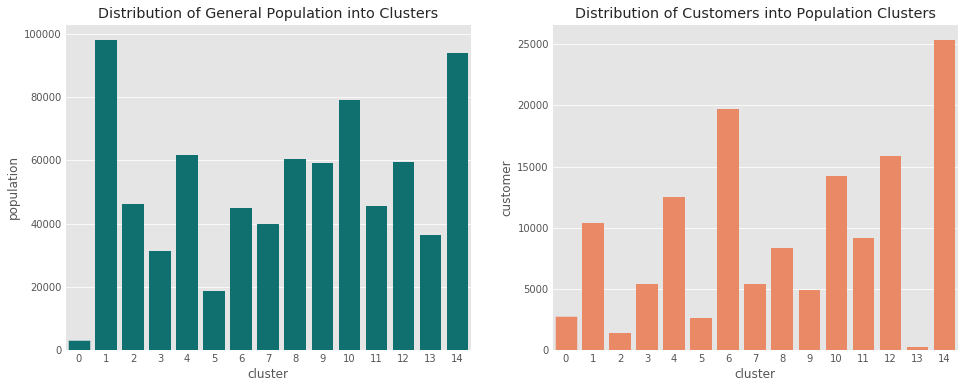

In [178]:
#Visualize dataframe as bar charts
fig = plt.figure(figsize=(16,6))

ax1 = fig.add_subplot(1,2,1)
ax1 = sns.barplot(x='cluster',y='population',color='teal',edgecolor='.9',data=cust_and_pop_cluster_df)
plt.title("Distribution of General Population into Clusters")

ax2 = fig.add_subplot(1,2,2)
ax2 = sns.barplot(x='cluster',y='customer',color='coral',edgecolor='.9',data=cust_and_pop_cluster_df)
plt.title("Distribution of Customers into Population Clusters")

In [179]:
# Add ratio and ratio difference for each cluster to the dataframe
cust_and_pop_cluster_df['pop_%'] = (cust_and_pop_cluster_df['population']/cust_and_pop_cluster_df['population'].sum()*100).round(2)
cust_and_pop_cluster_df['cust_%'] = (cust_and_pop_cluster_df['customer']/cust_and_pop_cluster_df['customer'].sum()*100).round(2)
cust_and_pop_cluster_df['diff'] = cust_and_pop_cluster_df['cust_%'] - cust_and_pop_cluster_df['pop_%']
cust_and_pop_cluster_df

,cluster,customer,population,pop_%,cust_%,diff
0,0,2778,3267,0.42,2.01,1.59
1,1,10385,98155,12.61,7.50,-5.11
2,2,1399,46137,5.93,1.01,-4.92
3,3,5419,31414,4.04,3.91,-0.13
4,4,12555,61617,7.92,9.07,1.15
5,5,2630,18746,2.41,1.90,-0.51
6,6,19695,45111,5.80,14.22,8.42
7,7,5402,39915,5.13,3.90,-1.23
8,8,8327,60438,7.76,6.01,-1.75
9,9,4937,59263,7.61,3.57,-4.04


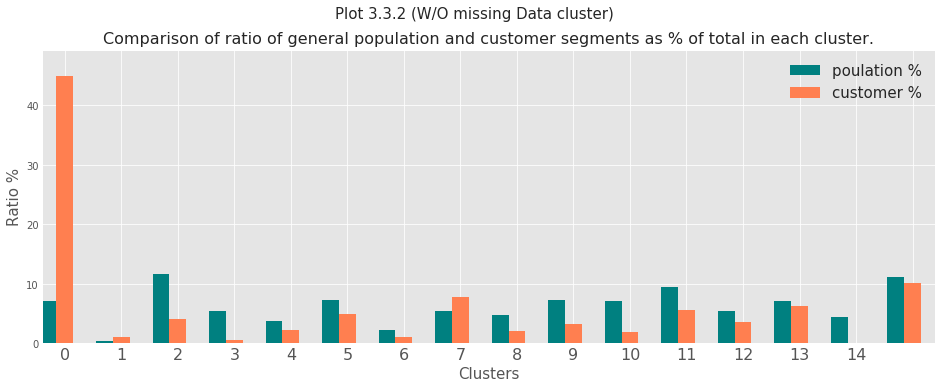

In [251]:
# Visualize ratios for each cluster

fig = plt.figure(figsize=(16,6))

ax = fig.add_subplot(111)

ax = cust_and_pop_cluster_df['pop_%'].plot(x=cust_and_pop_cluster_df['cluster'], kind='bar',color='teal',width=-0.3, align='edge',position=0)
ax = cust_and_pop_cluster_df['cust_%'].plot(kind='bar',color='coral',width = 0.3, align='edge',position=1)

ax.margins(x=0.5,y=0.1)
ax.set_xlabel('Clusters', fontsize=15) 
ax.set_ylabel('Ratio %', fontsize=15)
ax.xaxis.set(ticklabels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])
ax.tick_params(axis = 'x', which = 'major', labelsize = 16)
plt.xticks(rotation=360,)

plt.legend(('poulation %', 'customer %'),fontsize=15)
plt.title(('Comparison of ratio of general population and customer segments as % of total in each cluster.')
          ,fontsize=16)

plt.subplots_adjust(bottom=0.2)
plt.suptitle("Plot 3.3.2 (W/O missing Data cluster)", fontsize=15)
plt.show()

In [213]:
#Now, check the missing data 
pop_deleted_rows = azdias_subset_2.shape[0]
pop_delete_rows

112876

In [208]:
#Customer missing data
missing_row_data_2 = customers.isnull().sum(axis=1)


In [209]:
cust_rows_deleted = customers[customers.index.isin(missing_row_data_2[missing_row_data_2 > 10].index)]
cust_rows_deleted[:4]

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,NaN,4.0,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,3.0,2,5.0,4,2,4,4,3,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36,NaN,1.0,2,6.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37,NaN,3.0,2,6.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [219]:
cust_rows_deleted = cust_rows_deleted.shape[0]

In [227]:
# Add missing data rows as an extra cluster to dataframe
cust_and_pop_cluster_df.loc[-1] = ['-1', pop_deleted_rows, cust_rows_deleted,0,0,0]  # adding a row
cust_and_pop_cluster_df.index = cust_and_pop_cluster_df.index + 1  # shifting index
cust_and_pop_cluster_df.sort_index(inplace=True)

In [231]:
type(cust_and_pop_cluster_df)

pandas.core.frame.DataFrame

In [232]:
# Re-calculate ratios
cust_and_pop_cluster_df['pop_%'] = (cust_and_pop_cluster_df['population']/cust_and_pop_cluster_df['population'].sum()*100)
cust_and_pop_cluster_df['cust_%'] = (cust_and_pop_cluster_df['customer']/cust_and_pop_cluster_df['customer'].sum()*100).round(2)
cust_and_pop_cluster_df['diff'] = cust_and_pop_cluster_df['cust_%'] - cust_and_pop_cluster_df['pop_%']
cust_and_pop_cluster_df

,cluster,customer,population,pop_%,cust_%,diff
0,-1,112876,59220,7.0705,44.91,37.8395
2,0,2778,3267,0.390059,1.11,0.719941
3,1,10385,98155,11.7191,4.13,-7.58909
4,2,1399,46137,5.50847,0.56,-4.94847
5,3,5419,31414,3.75063,2.16,-1.59063
6,4,12555,61617,7.35668,5.00,-2.35668
7,5,2630,18746,2.23815,1.05,-1.18815
8,6,19695,45111,5.38597,7.84,2.45403
9,7,5402,39915,4.7656,2.15,-2.6156
10,8,8327,60438,7.21592,3.31,-3.90592


Text(0.5,1,'Distribution of Customers into Population Clusters')

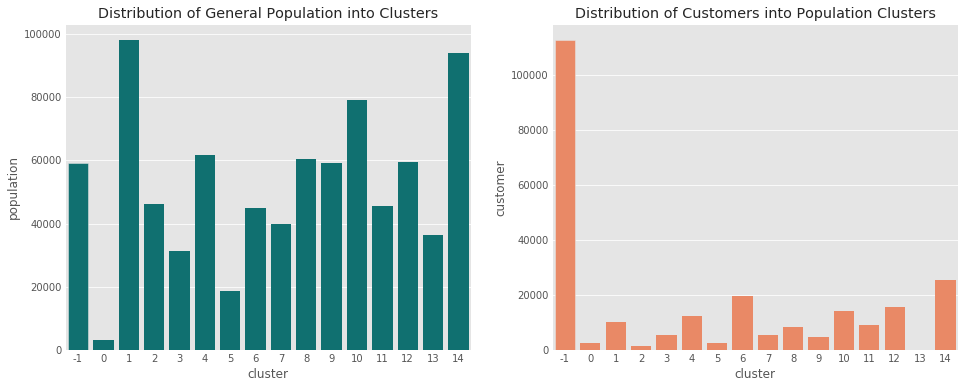

In [233]:
#Visualize dataframe as bar charts
fig = plt.figure(figsize=(16,6))

ax1 = fig.add_subplot(1,2,1)
ax1 = sns.barplot(x='cluster',y='population',color='teal',edgecolor='.9',data=cust_and_pop_cluster_df)
plt.title("Distribution of General Population into Clusters")

ax2 = fig.add_subplot(1,2,2)
ax2 = sns.barplot(x='cluster',y='customer',color='coral',edgecolor='.9',data=cust_and_pop_cluster_df)
plt.title("Distribution of Customers into Population Clusters")

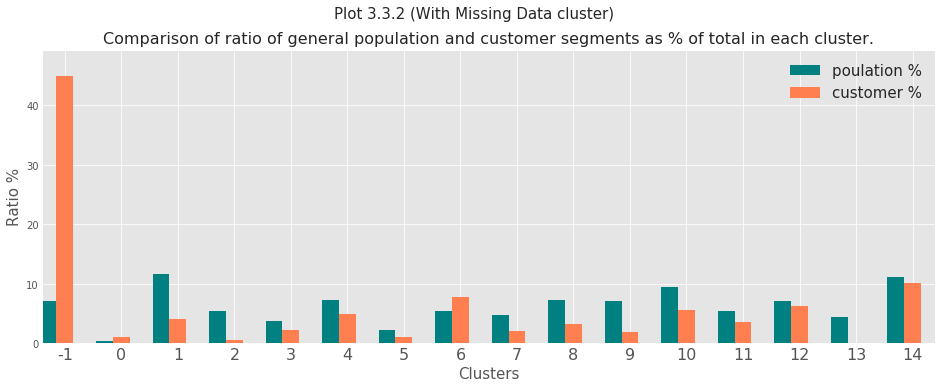

In [250]:
# Visualize ratios for each cluster

fig = plt.figure(figsize=(16,6))

ax = fig.add_subplot(111)

ax = cust_and_pop_cluster_df['pop_%'].plot(x=cust_and_pop_cluster_df['cluster'], kind='bar',color='teal',width=-0.3, align='edge',position=0)
ax = cust_and_pop_cluster_df['cust_%'].plot(kind='bar',color='coral',width = 0.3, align='edge',position=1)

ax.margins(x=0.5,y=0.1)
ax.set_xlabel('Clusters', fontsize=15) 
ax.set_ylabel('Ratio %', fontsize=15)
ax.xaxis.set(ticklabels=[-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])
ax.tick_params(axis = 'x', which = 'major', labelsize = 16)
plt.xticks(rotation=360,)

plt.legend(('poulation %', 'customer %'),fontsize=15)
plt.title(('Comparison of ratio of general population and customer segments as % of total in each cluster.')
          ,fontsize=16)

plt.subplots_adjust(bottom=0.2)
plt.suptitle("Plot 3.3.2 (With Missing Data cluster)", fontsize=15)
plt.show()

In [237]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

#Analyze cluster 6 that is over-represented by customer over population
# Analysis of principal components of cluster 7 that is over-represented by Customers.
cc6 = kmeans_15.cluster_centers_[6]
cc6 = pd.Series(cc6)
cc6.index = cc6.index +1
cc6.sort_values(ascending=False)

32    1.393349
31    1.324517
5     1.106095
43    1.038445
7     0.718378
4     0.615823
6     0.610367
30    0.558644
19    0.516814
38    0.504984
35    0.459165
29    0.425086
20    0.414452
40    0.351593
18    0.253777
23    0.223929
42    0.207780
21    0.181870
14    0.180147
10    0.093774
12    0.084599
3     0.010469
17   -0.010979
41   -0.065660
15   -0.068643
44   -0.116670
8    -0.177708
27   -0.186657
16   -0.212496
11   -0.316859
34   -0.319459
9    -0.330574
13   -0.344675
22   -0.355783
36   -0.357408
25   -0.371466
39   -0.404374
33   -0.468837
37   -0.474297
45   -0.478468
26   -0.498640
2    -0.538902
28   -0.573742
1    -0.629237
24   -0.713718
dtype: float64

In [252]:
# Transform cluster 6 to original feature values.
cc06 = scaler.inverse_transform(pca_2.inverse_transform(cc6))
cc06 = pd.Series(cc06).round(2)
cc06.index = columns_list
cc06.sort_values(ascending=False)

KBA13_ANZAHL_PKW        661.89
ALTER_HH                 19.00
WOHNDAUER_2008            8.99
INNENSTADT                4.94
ANZ_HAUSHALTE_AKTIV       4.70
SEMIO_ERL                 4.64
ORTSGR_KLS9               4.54
REGIOTYP                  4.52
SEMIO_LUST                4.52
DECADE                    4.51
SEMIO_DOM                 4.50
SEMIO_VERT                4.45
BALLRAUM                  4.41
SEMIO_PFLICHT             4.26
SEMIO_KAEM                4.25
ONLINE_AFFINITAET         4.21
SEMIO_SOZ                 4.17
SEMIO_KULT                4.15
ANZ_PERSONEN              4.08
SEMIO_REL                 3.99
SEMIO_RAT                 3.99
SEMIO_FAM                 3.91
GEBAEUDETYP_RASTER        3.87
KBA05_GBZ                 3.87
SEMIO_KRIT                3.85
MOBI_REGIO                3.81
SEMIO_TRADV               3.80
SEMIO_MAT                 3.69
FINANZ_MINIMALIST         3.69
PLZ8_GBZ                  3.68
                         ...  
LP_STATUS_FEIN_1.0        0.07
CJT_GESA

In [245]:
#Check the top and bottom features of top principal component
get_pc_primary_features(pca_2,'PC31')

Top 5 features for Principle component PC32 are:
CAMEO_DEUG_2015_3.0    0.497960
CJT_GESAMTTYP_2.0      0.251419
LP_FAMILIE_FEIN_8.0    0.236805
GFK_URLAUBERTYP_8.0    0.223864
CAMEO_DEUG_2015_9.0    0.170919
Name: PC32, dtype: float64
Bottom 5 features for Principle component PC32 are:
GFK_URLAUBERTYP_5.0   -0.293259
CAMEO_DEUG_2015_6.0   -0.274659
CJT_GESAMTTYP_1.0     -0.215970
CAMEO_DEUG_2015_2.0   -0.194718
CJT_GESAMTTYP_5.0     -0.138614
Name: PC32, dtype: float64


In [246]:
#Check the top and bottom features of top principal component
get_pc_primary_features(pca_2,'PC30')

Top 5 features for Principle component PC30 are:
LP_FAMILIE_FEIN_11.0    0.316975
CAMEO_DEUG_2015_6.0     0.256425
CAMEO_DEUG_2015_9.0     0.204340
LP_FAMILIE_FEIN_3.0     0.157337
GFK_URLAUBERTYP_9.0     0.156456
Name: PC30, dtype: float64
Bottom 5 features for Principle component PC30 are:
LP_FAMILIE_FEIN_10.0   -0.380921
CAMEO_DEUG_2015_7.0    -0.258060
GFK_URLAUBERTYP_3.0    -0.245036
CJT_GESAMTTYP_6.0      -0.190312
GFK_URLAUBERTYP_1.0    -0.182061
Name: PC30, dtype: float64


In [254]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# Analysis of principal components of cluster 1 that is over-represented by population.
pp1 = kmeans_15.cluster_centers_[1]
pp1 = pd.Series(pp1)
pp1.index = pp1.index +1
pp1.sort_values(ascending=False)

30    0.817192
1     0.660394
2     0.548664
22    0.480712
11    0.247138
25    0.231015
40    0.180800
5     0.148809
24    0.139913
43    0.135097
37    0.110327
19    0.093190
15    0.089690
35    0.081124
17    0.069402
41    0.062773
3     0.059971
38    0.035959
44    0.004483
7    -0.020489
14   -0.063479
18   -0.072925
12   -0.077159
45   -0.080721
21   -0.081509
29   -0.097369
6    -0.104885
13   -0.122181
8    -0.163825
42   -0.165919
20   -0.172226
16   -0.177455
4    -0.187596
34   -0.196538
36   -0.200793
39   -0.220670
33   -0.259063
10   -0.260834
9    -0.314132
32   -0.314275
28   -0.338525
31   -0.360585
27   -0.398019
23   -0.421729
26   -1.027320
dtype: float64

In [248]:
#Show featuresfor top principle component
get_pc_primary_features(pca_2,'PC29')

Top 5 features for Principle component PC29 are:
CAMEO_DEUG_2015_8.0    0.374082
LP_STATUS_FEIN_3.0     0.210566
LP_FAMILIE_FEIN_2.0    0.166570
LP_FAMILIE_FEIN_8.0    0.161276
CJT_GESAMTTYP_1.0      0.152302
Name: PC29, dtype: float64
Bottom 5 features for Principle component PC29 are:
LP_FAMILIE_FEIN_10.0   -0.279835
CAMEO_DEUG_2015_9.0    -0.259431
CAMEO_DEUG_2015_1.0    -0.200915
KBA05_ANTG3            -0.184512
SHOPPER_TYP_3.0        -0.179502
Name: PC29, dtype: float64


In [249]:
#Show featuresfor second top principle component
get_pc_primary_features(pca_2,'PC0')

Top 5 features for Principle component PC0 are:
PLZ8_ANTG3            0.187631
HH_EINKOMMEN_SCORE    0.181268
PLZ8_ANTG4            0.180786
ORTSGR_KLS9           0.167121
EWDICHTE              0.163892
Name: PC0, dtype: float64
Bottom 5 features for Principle component PC0 are:
FINANZ_MINIMALIST   -0.204324
MOBI_REGIO          -0.195248
PLZ8_ANTG1          -0.186855
KBA05_ANTG1         -0.184946
KBA05_GBZ           -0.182531
Name: PC0, dtype: float64


In [257]:
pp9 = kmeans_15.cluster_centers_[9]
pp9 = pd.Series(pp9)
pp9.index = pp1.index +1
pp9.sort_values(ascending=False)

2     0.827251
3     0.741619
27    0.615385
32    0.579719
34    0.526867
42    0.512686
10    0.390408
33    0.369311
18    0.368349
9     0.354574
21    0.321934
12    0.298435
6     0.277867
4     0.269439
15    0.261248
25    0.258966
28    0.256551
20    0.251244
40    0.193693
39    0.188508
46    0.155554
7     0.138206
26    0.128150
37    0.094247
30    0.090429
35    0.025594
44    0.024032
24   -0.004575
23   -0.032448
16   -0.046925
11   -0.057413
43   -0.076661
19   -0.095726
8    -0.111655
13   -0.135961
22   -0.136372
38   -0.165605
17   -0.182219
29   -0.202130
5    -0.238821
45   -0.264876
41   -0.328154
36   -0.497136
14   -0.590436
31   -0.817991
dtype: float64

In [255]:
#Show featuresfor top principle component
get_pc_primary_features(pca_2,'PC1')

Top 5 features for Principle component PC1 are:
ALTERSKATEGORIE_GROB    0.218478
FINANZ_VORSORGER        0.206296
ZABEOTYP_3              0.194607
SEMIO_ERL               0.172155
RETOURTYP_BK_S          0.154830
Name: PC1, dtype: float64
Bottom 5 features for Principle component PC1 are:
DECADE                  -0.219954
FINANZ_SPARER           -0.210200
FINANZ_UNAUFFAELLIGER   -0.205957
SEMIO_REL               -0.202533
FINANZ_ANLEGER          -0.197954
Name: PC1, dtype: float64


In [258]:
# Transform cluster 6 to original feature values.
pp09 = scaler.inverse_transform(pca_2.inverse_transform(pp9))
pp09 = pd.Series(pp09).round(2)
pp09.index = columns_list
pp09.sort_values(ascending=False)

KBA13_ANZAHL_PKW        507.80
ANZ_HAUSHALTE_AKTIV      20.44
ALTER_HH                 15.49
WOHNDAUER_2008            8.08
ORTSGR_KLS9               6.85
HH_EINKOMMEN_SCORE        5.61
REGIOTYP                  5.29
EWDICHTE                  5.09
SEMIO_ERL                 4.95
W_KEIT_KIND_HH            4.76
SEMIO_LUST                4.71
SEMIO_KRIT                4.61
SEMIO_VERT                4.41
SEMIO_DOM                 4.36
SEMIO_SOZ                 4.36
SEMIO_FAM                 4.33
SEMIO_KAEM                4.30
DECADE                    4.14
SEMIO_KULT                4.11
RETOURTYP_BK_S            4.04
SEMIO_MAT                 3.95
PLZ8_HHZ                  3.72
SEMIO_PFLICHT             3.71
FINANZ_HAUSBAUER          3.70
RELAT_AB                  3.69
FINANZ_VORSORGER          3.64
ARBEIT                    3.64
SEMIO_REL                 3.63
NBRHOODQUALITY            3.61
SEMIO_RAT                 3.43
                         ...  
CAMEO_DEUG_2015_5.0       0.04
ZABEOTYP

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

There is a big difference in considering the removed data as a cluster and not considering it. When we look at plot 3.3.2 (before removing the data) that shows ratios between customer and population proportions, there were 4 clusters with customer over-representation. But when you consider the removed data, the number of clusters dropped to 1. This big impact on ratios is due to large amount of missing data (almost 45%) in customer dataset as against only population data (only 7%). The cluster that showed up before and after removal of missing data cluster is 6.

On analyzing cluster 6 to understand what features contributed to customer over-representation, it looks like these are people from established middle class with family and grown up children. These people tend to go on vacations within their home country and prefer to use package travel (generally cheaper and does not require extensive planning). Perhaps these are people that are in their later stages who either live on pensions, 401k or taken up some part time jobs in their retirement. However, when I look at the next important principle component in this cluster, it looks like also people that are young and single parents

The below features are from the top 1 and top 2 principle components of cluster 6 that lead to my conclusion above on customer over-representation.

=================================================================================
##### Top Principle component features

CAMEO_DEUG_2015_3.0    0.497960 3: established middleclass
CJT_GESAMTTYP_2.0      0.251419 2: Advertising- and Consumptiontraditionalist
LP_FAMILIE_FEIN_8.0    0.236805 family with child of full age
GFK_URLAUBERTYP_8.0    0.223864 8: Homeland-connected vacationists
CAMEO_DEUG_2015_9.0    0.170919 -9: urban working class

Bottom 5 features for Principle component PC32 are:
GFK_URLAUBERTYP_5.0   -0.293259 5: Nature fans
CAMEO_DEUG_2015_6.0   -0.274659 6: low-consumption middleclass
CJT_GESAMTTYP_1.0     -0.215970 1: Advertising- and Consumptionminimalist
CAMEO_DEUG_2015_2.0   -0.194718 2: upper middleclass
CJT_GESAMTTYP_5.0     -0.138614 5: Advertising- and Cross-Channel-Enthusiast

##### Second Top Principle component features

Top 5 features for Principle component PC30 are:
LP_FAMILIE_FEIN_11.0    0.316975 multi-generational household
CAMEO_DEUG_2015_6.0     0.256425 6: low-consumption middleclass
CAMEO_DEUG_2015_9.0     0.204340  urban working class
LP_FAMILIE_FEIN_3.0     0.157337 young single parent
GFK_URLAUBERTYP_9.0     0.156456 Package tour travelers

Bottom 5 features for Principle component PC30 are:
LP_FAMILIE_FEIN_10.0   -0.380921 two-generational household
CAMEO_DEUG_2015_7.0    -0.258060 lower middleclass
GFK_URLAUBERTYP_3.0    -0.245036 Winter sportspeople
CJT_GESAMTTYP_6.0      -0.190312 Advertising-Enthusiast with restricted Cross-Channel-Behaviour

=========================================================

For Population over-representation there are many clusters (again this is due to huge missing data in customer data set that skewed the ratios) such as 1,2,4,8, 9 and 10. I focussed on clusters 1 and 9 where population is significatly over represented.

Individuals that are not customers for the mail order company, seem to be low to very low income earners whose consumption is minimal. From the features below, these people tend to fall in low income group. They don't own the apartments they live in and are probably renting. They have no interest in financial matters and move around alot as well as being not discernible shoppers.


The below features are from the top 1 principle components of cluster 1 and cluster 9 that lead to my conclusion above on population over-representation.

##### Top Principle component features (Cluster 1)
Top 5 features for Principle component PC29 are:
CAMEO_DEUG_2015_8.0    0.374082 8: working class
LP_STATUS_FEIN_3.0     0.210566 3: aspiring low-income earners
LP_FAMILIE_FEIN_2.0    0.166570 2: couple
LP_FAMILIE_FEIN_8.0    0.161276 8: family with child of full age
CJT_GESAMTTYP_1.0      0.152302 Advertising- and Consumptionminimalist

Bottom 5 features for Principle component PC29 are:
LP_FAMILIE_FEIN_10.0   -0.279835 two-generational household
CAMEO_DEUG_2015_9.0    -0.259431 urban working class
CAMEO_DEUG_2015_1.0    -0.200915 upper class
KBA05_ANTG3            -0.184512
SHOPPER_TYP_3.0        -0.179502 family-shopper

##### Top Principle component features (Cluster 9)

Top 5 features for Principle component PC1 are:
ALTERSKATEGORIE_GROB    0.218478
FINANZ_VORSORGER        0.206296 Score 3.64 signifying low wage earner
ZABEOTYP_3              0.194607 3: fair supplied
SEMIO_ERL               0.172155 Score 3.63 signifying average affinity
RETOURTYP_BK_S          0.154830 Score 3.60 signifying conservative Low-Returner

Bottom 5 features for Principle component PC1 are:
DECADE                  -0.219954
FINANZ_SPARER           -0.210200
FINANZ_UNAUFFAELLIGER   -0.205957
SEMIO_REL               -0.202533
FINANZ_ANLEGER          -0.197954
Name: PC1, dtype: float64

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.